# pQCD calculations: Pressure and sound speed squared

## Author: Alexandra Semposki

### Date last edited: 16 February 2024

This interactive Jupyter notebook walks us through the calculation of perturbative QCD (pQCD) using the general form of the pressure, $P(\mu)$, given in [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902), in the Supplemental Material, up to and including N$^{2}$LO. This notebook generates some of the figures in our paper, by A. Semposki, C. Drischler, R. J. Furnstahl, J. A. Melendez, and D. R. Phillips, for the pQCD EOS section.

The first half of this notebook calculates the pressure with respect to the chemical potential, and shows results when BUQEYE truncation error methods are applied to estimate the uncertainties from higher order terms. The second half of the notebook then performs the transformation of this equation to $P(n)$ using the well-known example of Kohn, Luttinger, and Ward (henceforth referred to here as the "KLW inversion" or "KLW method"). The details of theory behind this method can be found in Fetter and Walecka's "Quantum Theory of Many Particle Systems", or in the original papers, found [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.41) and [here](https://journals.aps.org/pr/abstract/10.1103/PhysRev.118.1417). After calculating $P(n)$ up to the same order, we compute the sound speed squared, $c_{s}^{2}(n)$.

This notebook can be easily altered to reflect the pQCD EOS for asymmetric nuclear matter, and also can be modified to include the recent results from [Gorda et al. (2023)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.181902) at N$^{3}$LO, if desired. 

#### Table of contents

1. [Calculation of $P(\mu)$](#calc_p_mu)
1. [Calculation of $P(n)$](#calc_p_n)
  1. [Computing the sound speed squared](#cs2) 
  1. [Saving the data for the GP package](#gp_data)

In [45]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import numpy as np
import numdifftools as ndt
import scipy.stats as stats
import os
from IPython.display import Image
import sys
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

sys.path.append('src/')
sys.path.append('data/')

import scipy.integrate as sc
import scipy.optimize as opt
from collections import defaultdict

from pqcd_reworked import PQCD
from truncation_error import Truncation

from scripts import *
setup_rc_params()

%matplotlib inline

edgewidth = 0.3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# legend plotter from ChEFT code copied here
import sys
sys.path.append('nuclear-matter-convergence/')  ## for me this is in this repo
from nuclear_matter.graphs import *
from nuclear_matter import lighten_color

# define order list now
orders = [0,1,2]

# plotting assistance
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

## $P(\mu)/P_{FG}(\mu)$ <a id="calc_p_mu"></a>

Here we calculate the scaled pressure, since we will be needing this quantity for the model mixing step of this work. We divide by the Fermi gas pressure.

In [47]:
n0 = 0.16   # fm-3

In [48]:
# coefficient functions
x = np.linspace(0.4, 2.5, 100)  # mu_q for us
x_B = 3.0*np.linspace(0.4, 2.5, 100)

X = x[:, None]  # make a 2D version of x to match the input data structure from SciKitLearn
n_orders = 3    # Here we examine the case where we have info on two non-trivial orders (0,1,2)
orders = np.arange(0, n_orders)

# try only using the N2LO coefficient
# This ensures we only analyze the non-trivial information at
# O(Q^2)
excluded = [0, 1]
orders_mask = ~ np.isin(orders, excluded)   # masking orders to exclude them from training

pqcd = PQCD(X=1,Nf=2)

coeffs = np.array([pqcd.c_0(x), pqcd.c_1(x), pqcd.c_2(x)]).T 

In [49]:
# plot the new and old pressures; should be the same
# plt.plot(x, pqcd.pressure_mu(x, order=2)/pqcd.pressure_FG(x))
# plt.plot(x, pqcd.pressure_old(x, order=2)/pqcd.pressure_FG(x))

In [50]:
# using the classes to get the results
# employs gsum for interpolation and truncation GPs
# send the orders and mask into the truncation class
trunc = Truncation(x, x_FG=None, norders=3, orders=orders, yref=pqcd.yref, \
                   expQ=pqcd.expQ, coeffs=coeffs, mask=orders_mask)

Text(0.5, 0, '$x$')

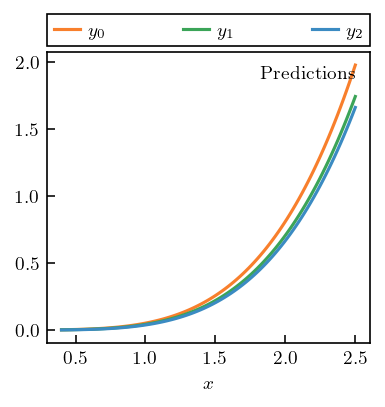

In [51]:
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor='k',
    mode='expand',
    fancybox=False
)

fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i, curve in enumerate(trunc.data.T):
    ax.plot(x, curve, label=r'$y_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Predictions', ha='right', va='top',
        transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')


Text(0.5, 0, '$x$')

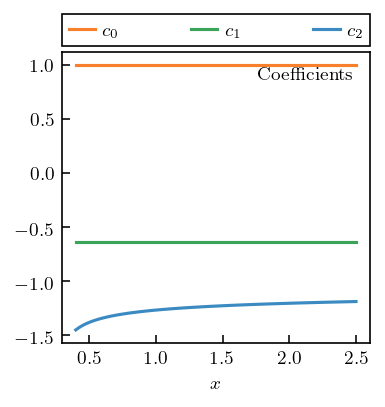

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i,n in enumerate(orders):
    ax.plot(x, trunc.coeffs[:, i], label=r'$c_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Coefficients', ha='right', va='top',
           transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')

In [53]:
# now fit and predict with the GP
pred, std, underlying_std = trunc.gp_interpolation(center=0.0, sd=1.0)

# print the shapes
pred = pred[:,None]

RBF(length_scale=8.63) + WhiteKernel(noise_level=9.97e-05)
2.255796036957152


(100, 1) (100, 3)
RBF(length_scale=8.63) + WhiteKernel(noise_level=9.97e-05)
2.255796036957152


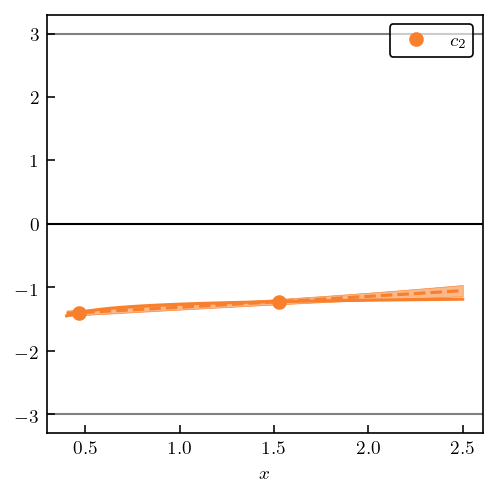

In [54]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
print(pred.shape, trunc.coeffs.shape)
for i, n in enumerate(orders[2:]):
    ax.plot(x, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(x, trunc.coeffs_trunc[:, i], c=colors[i], zorder=i-5)
    ax.plot(x[trunc.mask], trunc.coeffs_trunc[trunc.mask, i], c=colors[i], zorder=i-5, ls='', marker='o',
            label=r'$c_{}$'.format(n))
    ax.fill_between(x, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)

print(trunc.gp_interp.kernel_)
print(trunc.gp_interp.cov_factor_)

# Format
ax.axhline(2*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c='gray', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c='k', zorder=-10, lw=1)
ax.set_xlabel(r'$x$')
ax.tick_params(which='minor', bottom=True, top=False)
ax.legend(ncol=2, borderaxespad=0.5, borderpad=0.4)


In [55]:
# calculates results
data, coeffs, std = trunc.uncertainties(data=None, expQ=pqcd.expQ, yref=pqcd.yref)

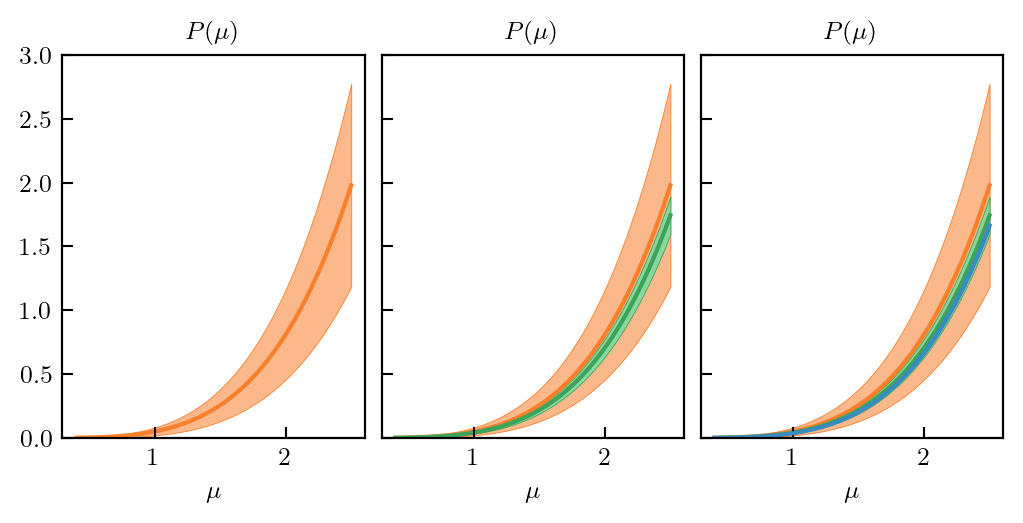

In [56]:
# plot the results here to check the class
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(x, data[:, i], zorder=i, c=colors[i])
        ax.fill_between(x, data[:, i] + 1.96*std[:,i], data[:, i] - 1.96*std[:,i],
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_ylim(0,3)
    ax.set_xlabel(r'$\mu$')
    ax.set_title(r'$P(\mu)$')

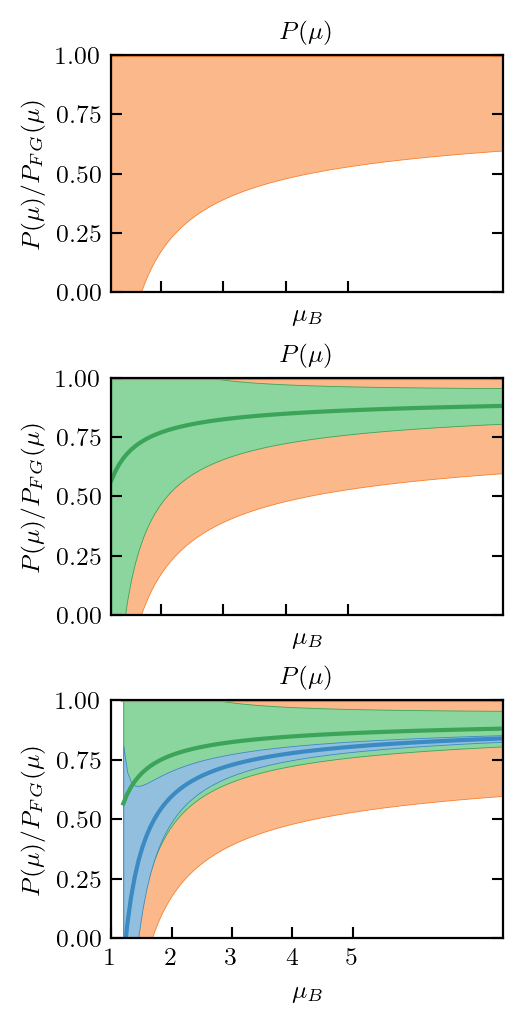

In [57]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(2.5, 5), dpi=200)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(3.0 * x, data[:, i]/pqcd.yref(X), zorder=i, c=colors[i])
        ax.fill_between(3.0 * x, (data[:, i] + 1.96*std[:,i])/pqcd.yref(X), (data[:, i] - 1.96*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_ylim(0,1)
    ax.set_xlim(min(3.0*x), max(3.0*x))
    ax.set_xlabel(r'$\mu_{B}$')
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
    ax.set_title(r'$P(\mu)$')
    ax.set_xticks([1,2,3,4,5])
    ax.tick_params(right=True)

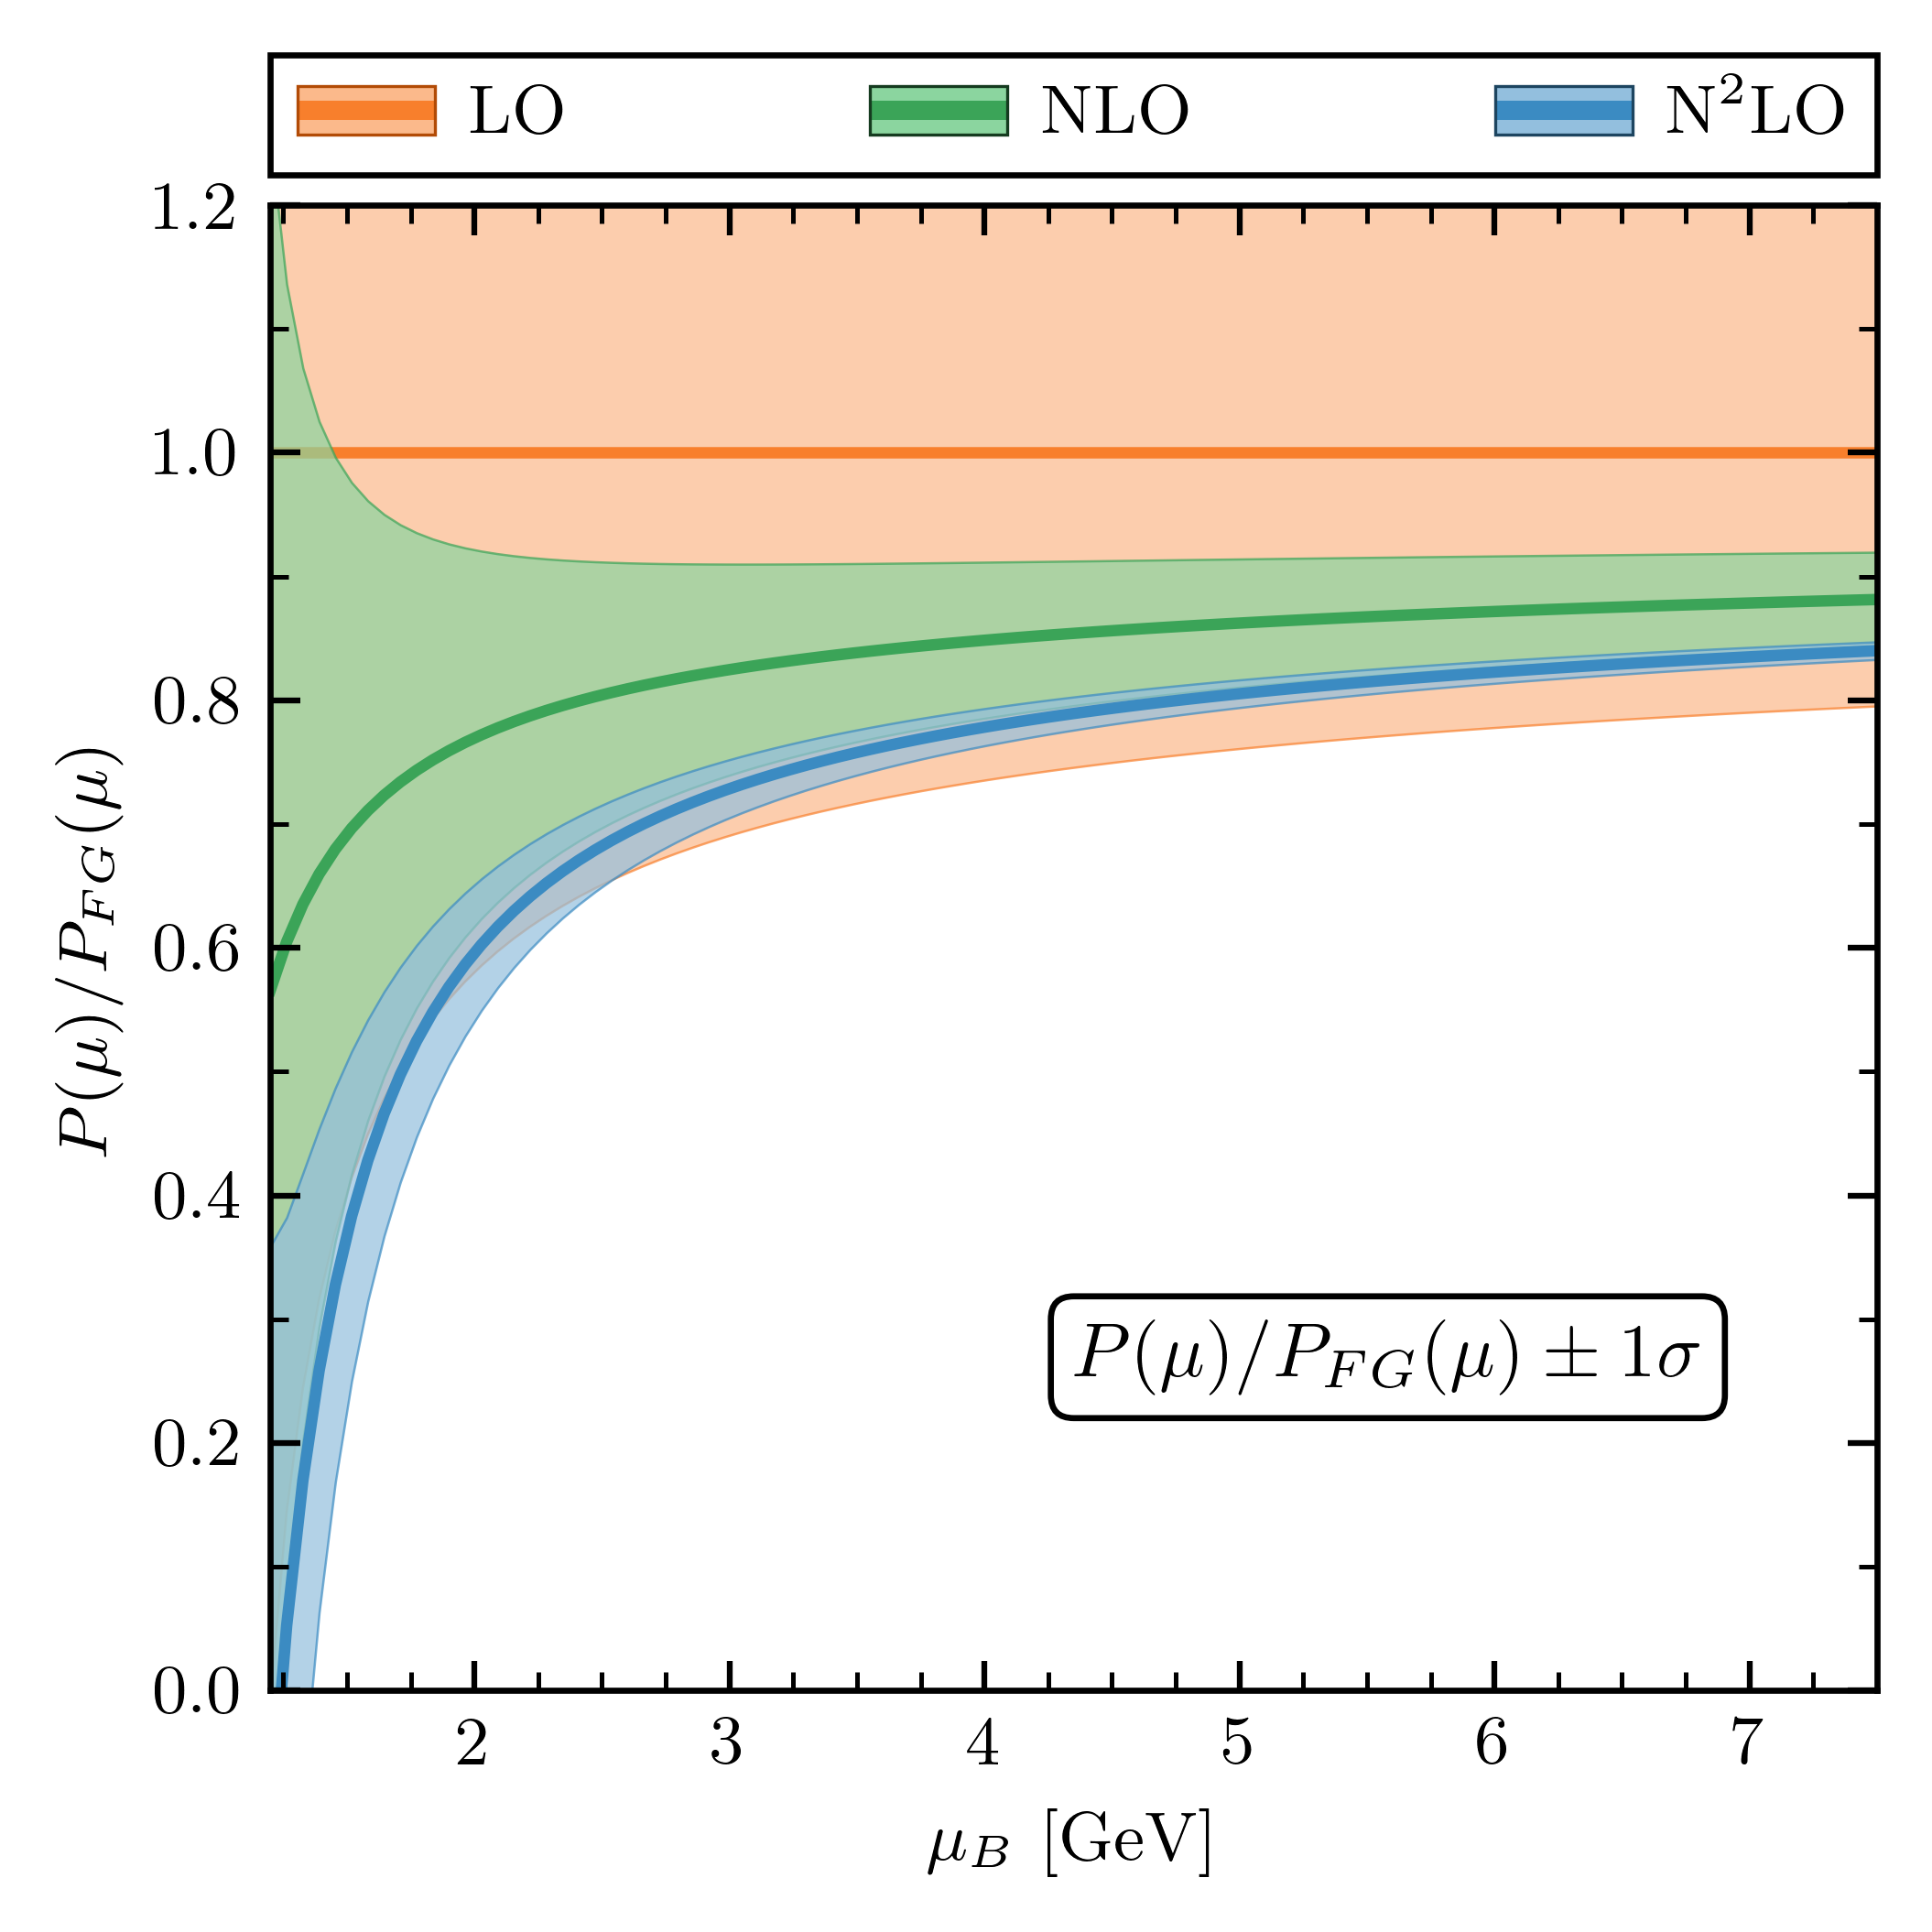

In [58]:
labels = [r'LO', r'NLO', r'N$^{2}$LO']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(3.0 * x, data[:, i]/pqcd.yref(X), zorder=i-1, c=colors[i])
    ax.fill_between(3.0 * x, (data[:, i] + 1.0*std[:,i])/pqcd.yref(X), (data[:, i] - 1.0*std[:,i])/pqcd.yref(X),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.0,1.2)
    ax.set_xlim(min(3.0 * x), max(3.0 * x))
    ax.set_ylabel(r'$P(\mu)/P_{FG}(\mu)$')
ax.set_xlabel(r'$\mu_{B}$ [GeV]')
title = r'$P(\mu)/P_{FG}(\mu) \pm 1\sigma$'
ax.text(
    0.50, 0.25, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)
#fig.tight_layout(h_pad=0.3, w_pad=0.3);

#fig.savefig('pqcd_pressure_mu.pdf')

In [59]:
# print(x[12])
# print(x_B[12])  # mu_B
# print('For mu_B = 1 GeV, results:')
# print('LO:', (data[:, 0]/pqcd.yref(X))[12])
# print('NLO:', (data[:, 1]/pqcd.yref(X))[12])
# print('N2LO:', (data[:, 2]/pqcd.yref(X))[12])

Number of points in training set: 2
Number of points in validation set: 3

Training set: 
 [[0.46363636]
 [1.52424242]]

Validation set: 
 [[1.03636364]
 [1.67272727]
 [2.30909091]]
0.9552963377854463
Std. dev. expected value: 0.9552963377854463
Calculated value : 0.5807397864458181
Trained kernel:  RBF(length_scale=8.63) + WhiteKernel(noise_level=9.97e-05)
Diagnostic kernel:  RBF(length_scale=10.8) + WhiteKernel(noise_level=9.96e-05)
[[0.91268195 0.91099515 0.90622403]
 [0.91099515 0.91268195 0.91099515]
 [0.90622403 0.91099515 0.91268195]]
Condition number: 28880.454005446994


/Users/alexandra/Documents/EOSBMM/buqeyenm/src/truncation_error.py:341: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout();


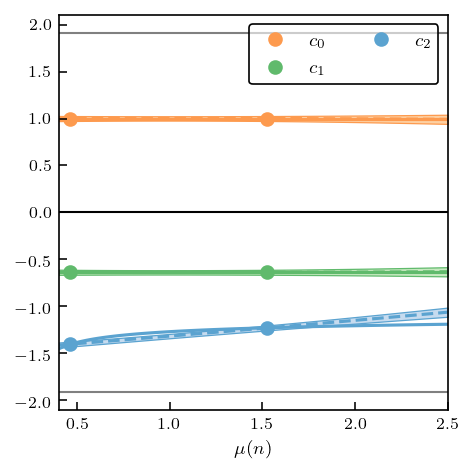

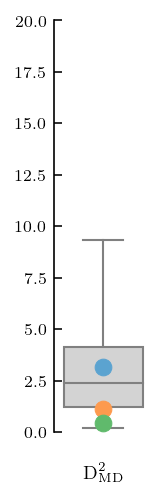

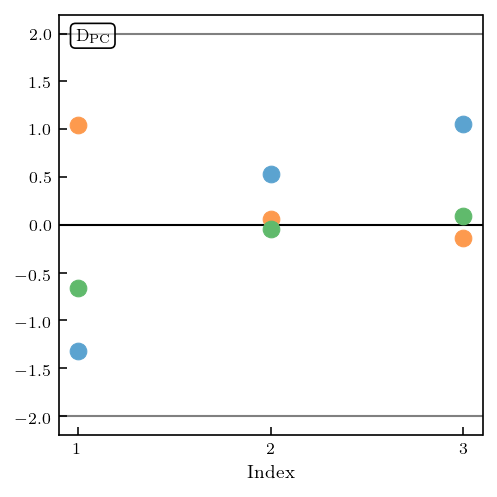

In [60]:
# call the diagnostics here to test before using on number density results
trunc.diagnostics(50,30)

## Speed of sound squared, $c_{s}^{2}(\mu)$

In [61]:
# plot each order
# plt.ylim(0.2,0.4)
# plt.plot(x*3.0, 0.3333*np.ones(len(x)), label=r'LO')
# plt.plot(x*3.0, 0.3333*np.ones(len(x)), linestyle='dashed', label=r'NLO')
# plt.plot(x*3.0, 0.3333*np.ones(len(x)) - 0.0544132*pqcd.alpha_s(x, loop=2)**2.0, label=r'N2LO') # Nf = 2 currently
# print((0.3333*np.ones(len(x)) - 0.136033*pqcd.alpha_s(x, loop=2)**2.0)[-1])
# plt.xlabel(r'$\mu_{B}$ [GeV]')
# plt.ylabel(r'$c_{s}^{2}(\mu)$')
# plt.legend()
# #plt.savefig('speedofsoundmu.pdf')

## $P(n)/P_{FG}(n)$ <a id="calc_p_n"></a>

In [62]:
#now find n corresponding to the mu array here first
n_mu = pqcd.n_mu(x)  

# now we would like to get a mu array corresponding to the n we desire
n = np.linspace(0.05, 16.0, 600) # baryon number density from chiral EFT [fm^-3]

# convert this quark number density first
n_q = n*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q
conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
n_q = n_q/conversion_fm3

# plt.plot(x, pqcd.n_mu(x), label=r'$n(\mu)$')
# plt.plot(x, pqcd.n_FG_mu(x), label=r'$n_{FG}(\mu)$')
# plt.xlabel(r'$\mu_q$ [GeV]')
# plt.ylabel(r'$n(\mu)$ [GeV$^3$]')
# plt.legend()

### Setting up $n$ to obtain corresponding $\mu_{FG}(n)$

In [88]:
# now we would like to get a mu array corresponding to the n we desire
n = np.linspace(11.2, 16.0, 350) # baryon number density from chiral EFT [fm^-3]
#n = np.linspace(0.05, 16.0, 600)
dens = n

# convert this quark number density first
n_q = n*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q
conversion_fm3 = ((1000.0)**(3.0))/((197.33)**(3.0)) # [fm^-3]  (do the opposite of this)
n_q = n_q/conversion_fm3  # [GeV^3]

# invert to get mu
_, mu_n, mu_FG = pqcd.inversion(n_mu=n_q)  # [GeV] # these are quark chemical potentials

mU_FG = mu_FG[:,None]   # [GeV] 

In [89]:
# solve for value of density at a given mu value
# pqcd = PQCD(1,2)
# #mu_val_B = 3.0  # GeV for baryons
# mu_val_q = 0.41 #mu_val_B/3.0   # GeV for quarks
# print(mu_val_q)
# n_val_q = pqcd.n_mu(mu_val_q) # GeV^3 for quarks
# print(n_val_q)
# n_val_B = n_val_q / 3.0 # GeV^3 for baryons
# n_val_B_fm = n_val_B*conversion_fm3
# print(n_val_B_fm)

# print('Value of density for baryons in terms of n0:', n_val_B_fm/n0)

In [90]:
# plot the alpha_s curve vs chemical potential and vs number density
# from mpl_toolkits.axes_grid1.parasite_axes import HostAxes
# fig = plt.figure(figsize=(8,6), dpi=200)
# #ax = fig.add_subplot(axes_class=HostAxes, aspect=1)
# ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
# ax2.set_xlabel(r'n [fm$^{-3}$]', fontsize=16)  # we already handled the x-label with ax1
# ax2.plot(n, np.zeros(len(n)))
# ax2.tick_params(axis='y')
# ax.set_xlabel(r'$\mu_{q}$ [GeV]', fontsize=16)
# ax.set_ylabel(r'$\alpha_{s}(\mu)$', fontsize=16)
# ax2.axis["right"].major_ticklabels.set_visible(False)
# ax2.axis["top"].major_ticklabels.set_visible(True)
# ax.tick_params(axis='both', which='major', labelsize=16)
# ax.tick_params(axis='both', which='minor', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.tick_params(axis='both', which='minor', labelsize=14)
# plt.ylim(0.2,0.8)
# plt.plot(mu_n, pqcd.alpha_s(mu_n), color='k', linewidth=4)
# plt.show()

In [91]:
# using the classes to get the results (same as with the results from P(mu))
coeffs_new = np.array([pqcd.c_0(mu_n), pqcd.c_1(mu_n), pqcd.c_2(mu_n)]).T
trunc_new = Truncation(mu_n, x_FG=mu_FG, norders=3, orders=orders, yref=pqcd.yref, expQ=pqcd.expQ, coeffs=coeffs_new)

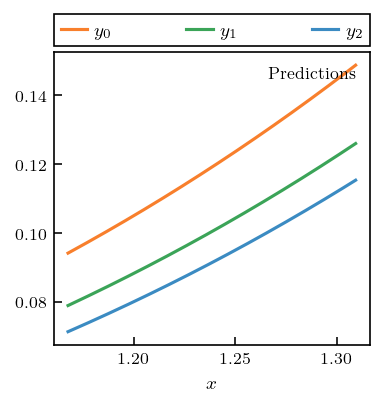

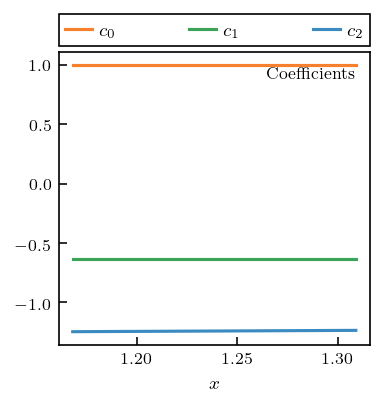

In [92]:
# checking plots
top_legend_kwargs = dict(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1, 0.5), ncol=4,
    borderpad=0.37,
    labelspacing=0.,
    handlelength=1.4,
    handletextpad=0.4, borderaxespad=0,
    edgecolor='k',
    mode='expand',
    fancybox=False
)

fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i, curve in enumerate(trunc_new.data.T):
    ax.plot(mu_n, curve, label=r'$y_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Predictions', ha='right', va='top',
        transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')

# checking coefficients
fig, ax = plt.subplots(1, 1, figsize=(2.45, 2.6))

for i in range(n_orders):
    ax.plot(mu_n, trunc_new.coeffs[:, i], label=r'$c_{}$'.format(i), c=colors[i])

ax.text(0.95, 0.95, 'Coefficients', ha='right', va='top',
           transform=ax.transAxes)

legend = ax.legend(**top_legend_kwargs)

# Format
ax.set_xlabel(r'$x$')

# checking this result if possible
pressure_check = pqcd.pressure_mu(2.5) # this works so we're still OK

In [93]:
data, std, underlying_std = trunc_new.gp_interpolation() # data is coeffs!

RBF(length_scale=6.89e+03) + WhiteKernel(noise_level=1e-05)
1.1222617606876095


The above uses the data at mu of all orders (mu_n) to get the proper coefficient interpolation and kernel. Now that we've got this trained on the coeffs at mu_n, we want to reconstruct the pressure using only specific orders of mu, and establishing truncation error that has been calculated only at mu_FG.

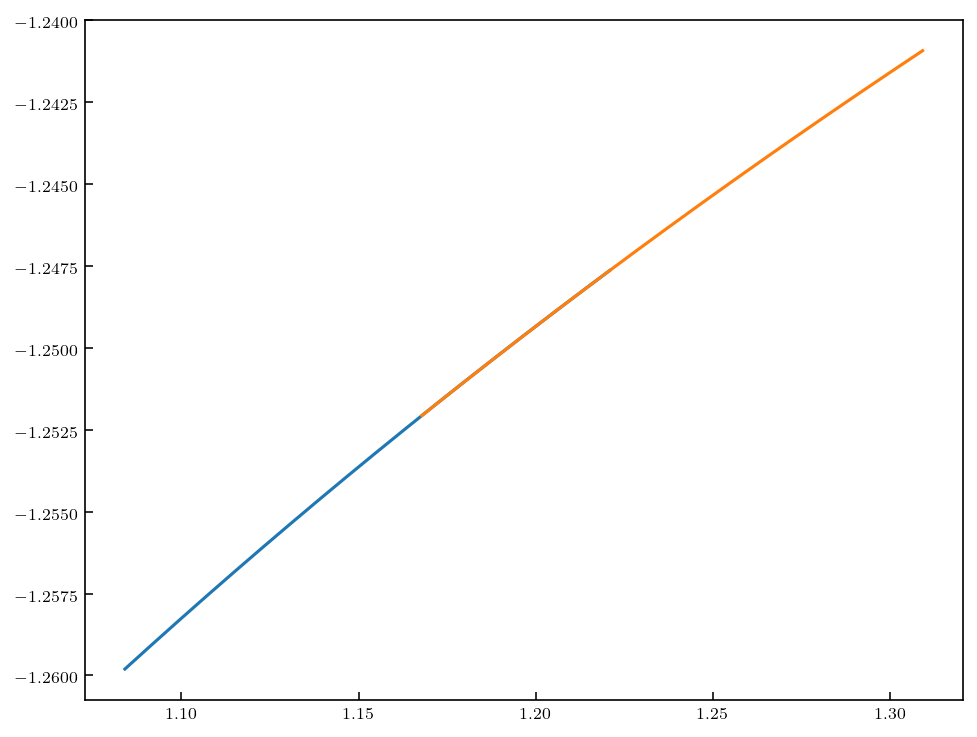

In [94]:
# construct data from mu_FG data now for truncation GP
plt.plot(mu_FG, pqcd.c_2(mu_FG))
plt.plot(mu_n, pqcd.c_2(mu_n))
coeffs_FG = np.array([pqcd.c_0(mu_FG), pqcd.c_1(mu_FG), pqcd.c_2(mu_FG)]).T
data_FG = gm.partials(coeffs_FG, ratio=pqcd.expQ(mU_FG), ref=pqcd.yref(mU_FG), orders=[range(3)])

In [95]:
data_trunc, coeffs_trunc, std_trunc = trunc_new.uncertainties(data=data_FG, expQ=pqcd.expQ, yref=pqcd.yref)
cov_trunc = trunc_new.cov_trunc

for j in range(len(orders)):
    for i in range(len(std_trunc)):
        if np.isnan(std_trunc[i,j]) == True or np.isinf(std_trunc[i,j]) == True:
            std_trunc[i,j] = 1e10

Text(0.1, 0.9, '$P(n)$ [MeV/fm$^{3}$]')

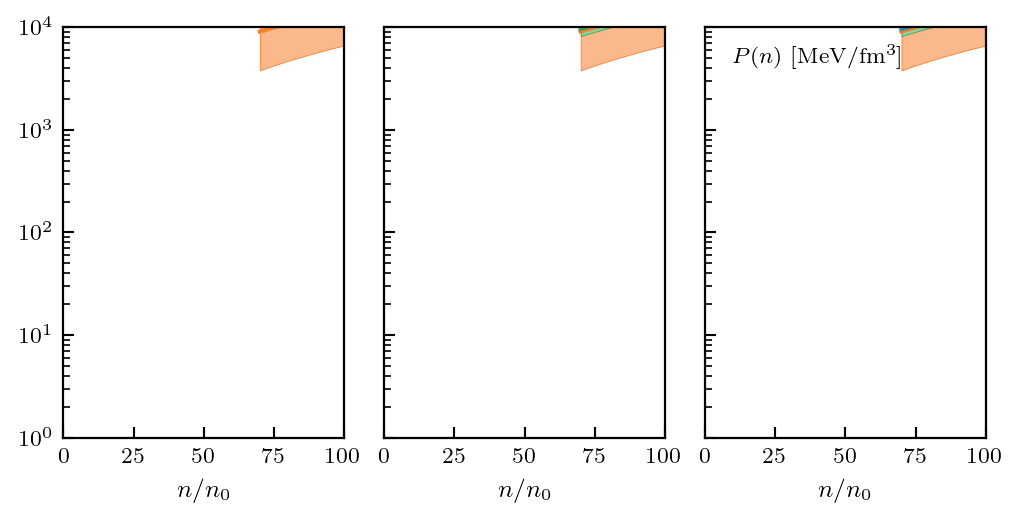

In [96]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 2.5), dpi=200)
conversion = (1000)**4.0/(197.327)**3.0 

# call KLW function for pressure and assign to array
pressure_n_KLW = pqcd.pressure_KLW(mu_FG)
corrected_pressure = np.array([pressure_n_KLW["LO"], pressure_n_KLW["NLO"], pressure_n_KLW["N2LO"]]).T

for i, n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.set_xlim(0.0, 100.0)
        ax.set_yscale('log')
        ax.set_ylim(1.0,10000)
        ax.plot(dens/n0, corrected_pressure[:,i]*conversion, zorder=i, c=colors[i])
        ax.fill_between(dens/n0, corrected_pressure[:, i]*conversion + 1.96*std_trunc[:,i]*conversion, \
                        corrected_pressure[:, i]*conversion - 1.96*std_trunc[:,i]*conversion,
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.set_xlabel(r'$n/n_{0}$')
ax.text(0.1, 0.9, r'$P(n)$ [MeV/fm$^{3}$]', ha='left', va='bottom',
           transform=ax.transAxes, fontsize=8)

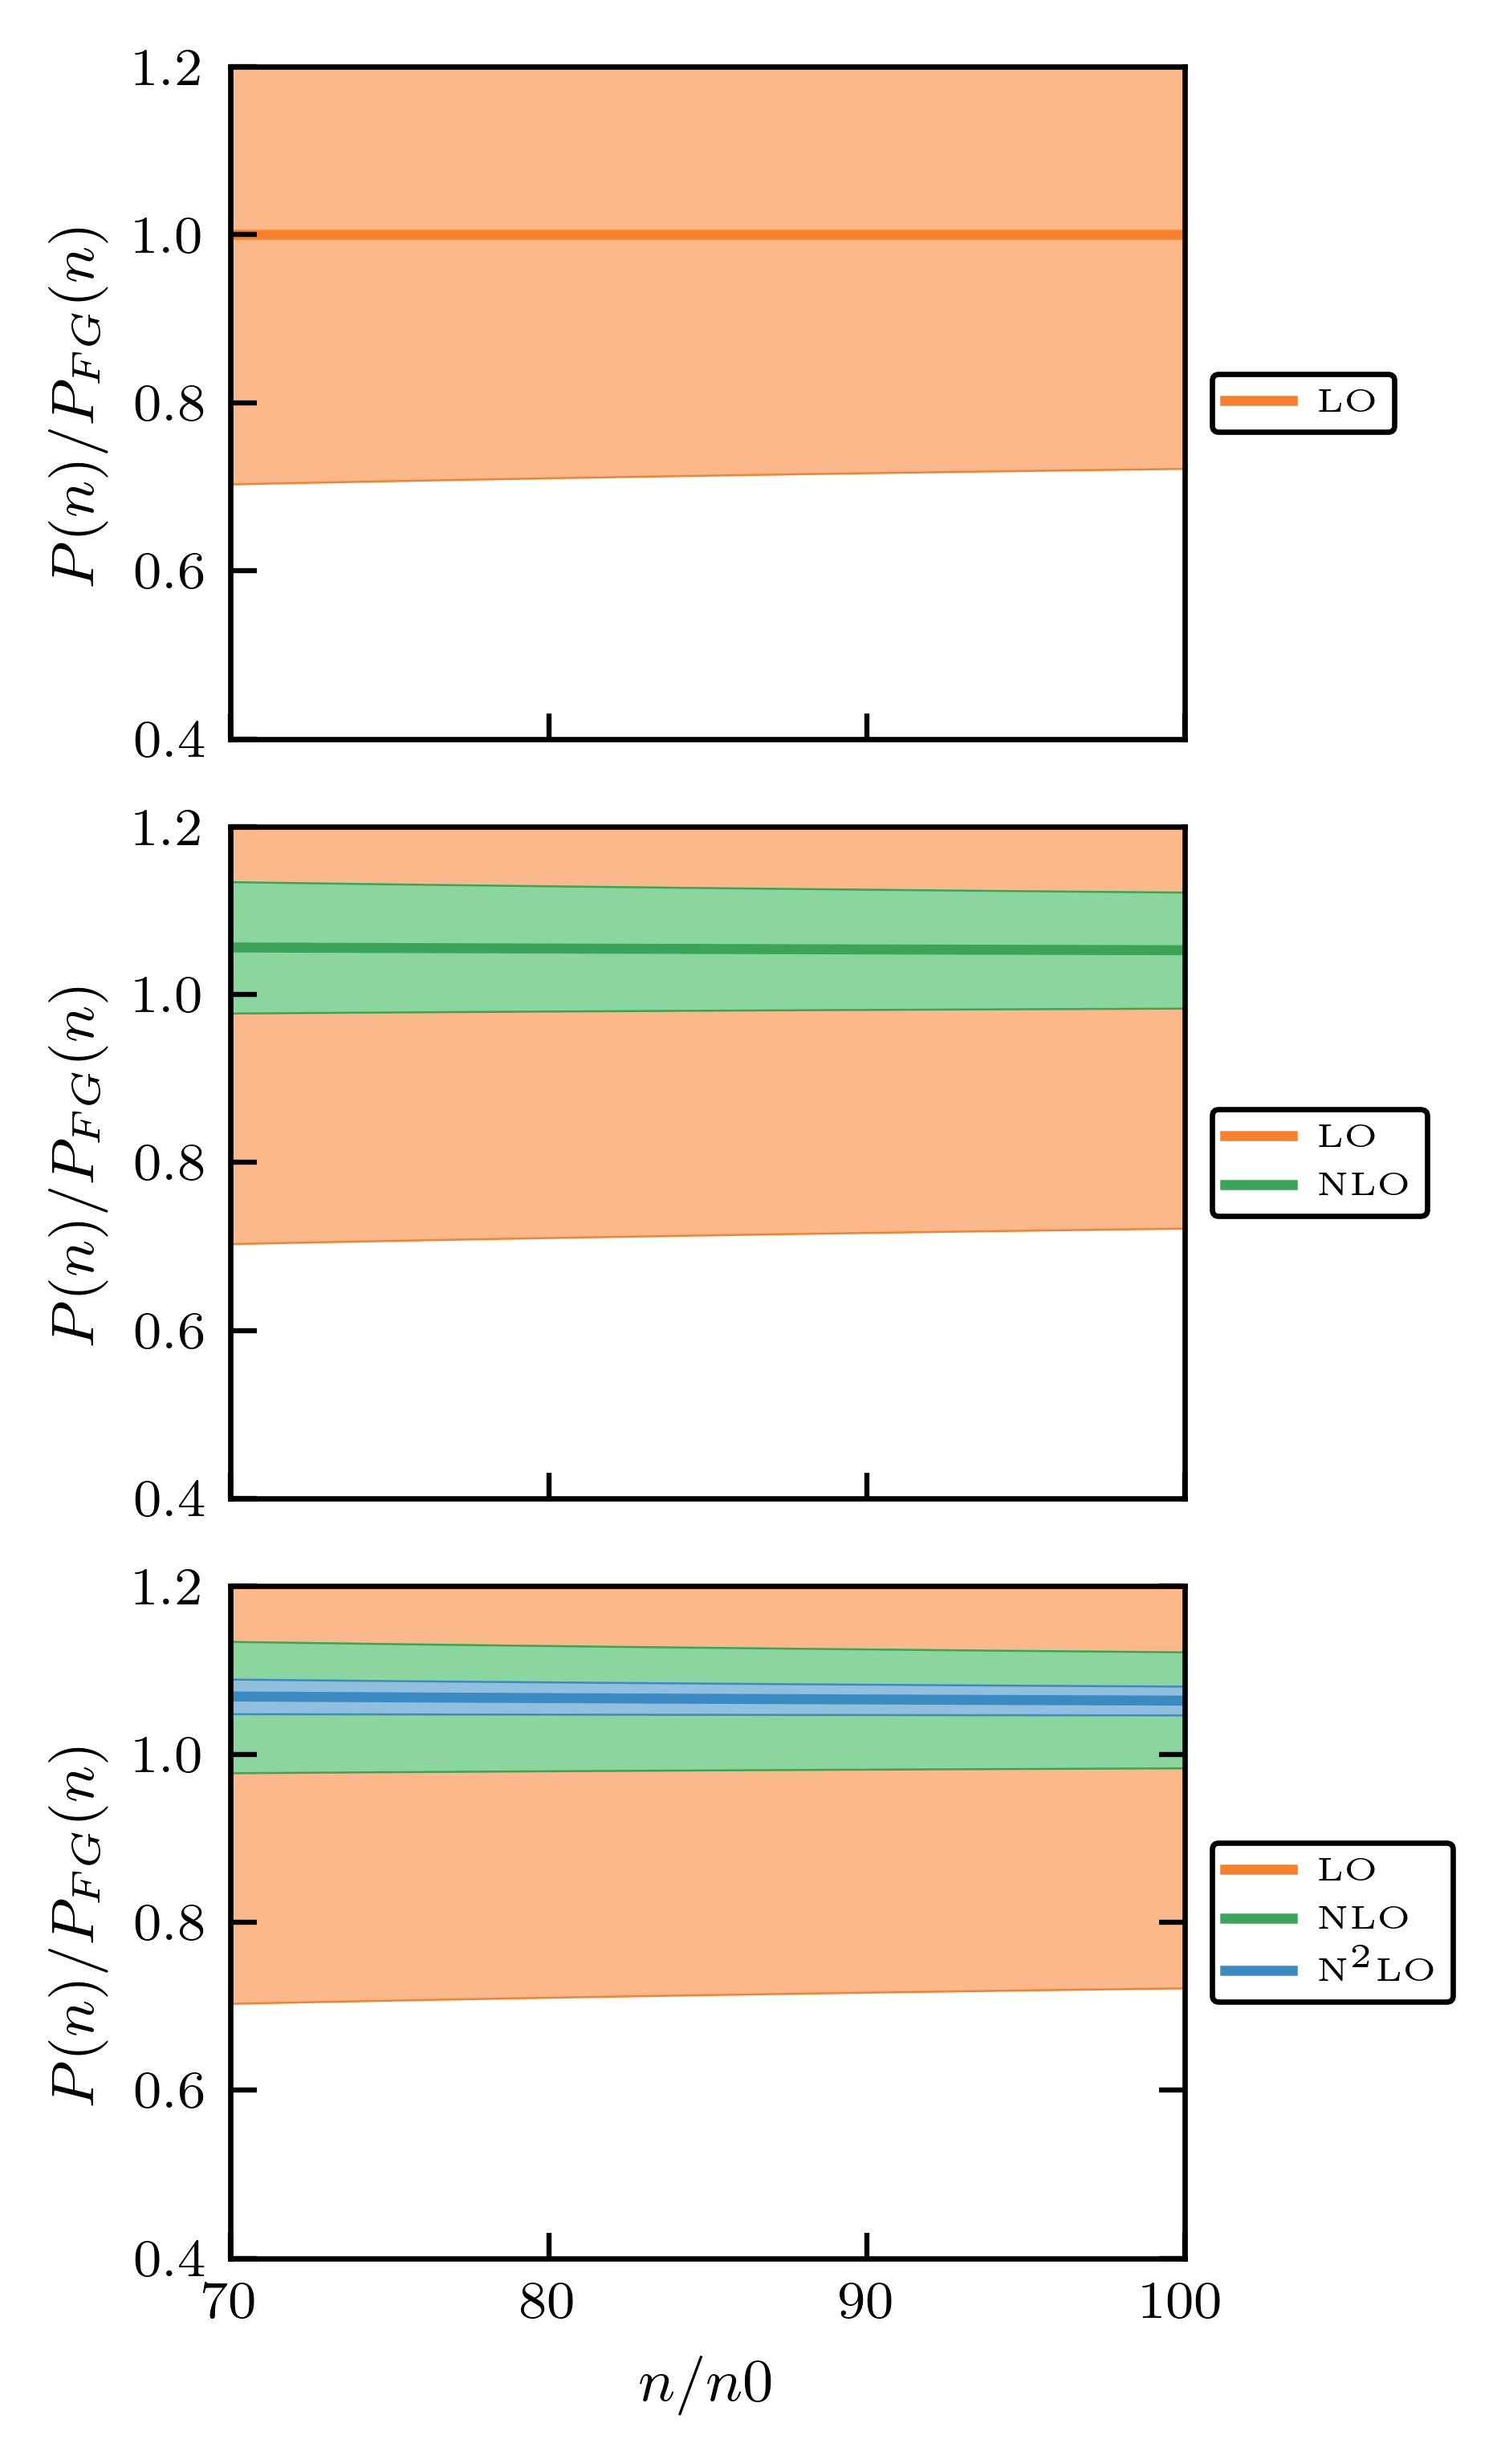

In [97]:
X = mu_n[:,None]
X_FG = mu_FG[:,None]  
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(3,5), dpi=600)

for i,n in enumerate(orders):
    for j in range(i, 3):
        ax = axes.ravel()[j]
        ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
        ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc[:,i])/pqcd.yref(X_FG), (corrected_pressure[:, i] - 1.0*std_trunc[:,i])/pqcd.yref(X_FG),
                        zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=5)
    ax = axes.ravel()[i]
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(min(dens)/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n0$')
ax.tick_params(right=True)

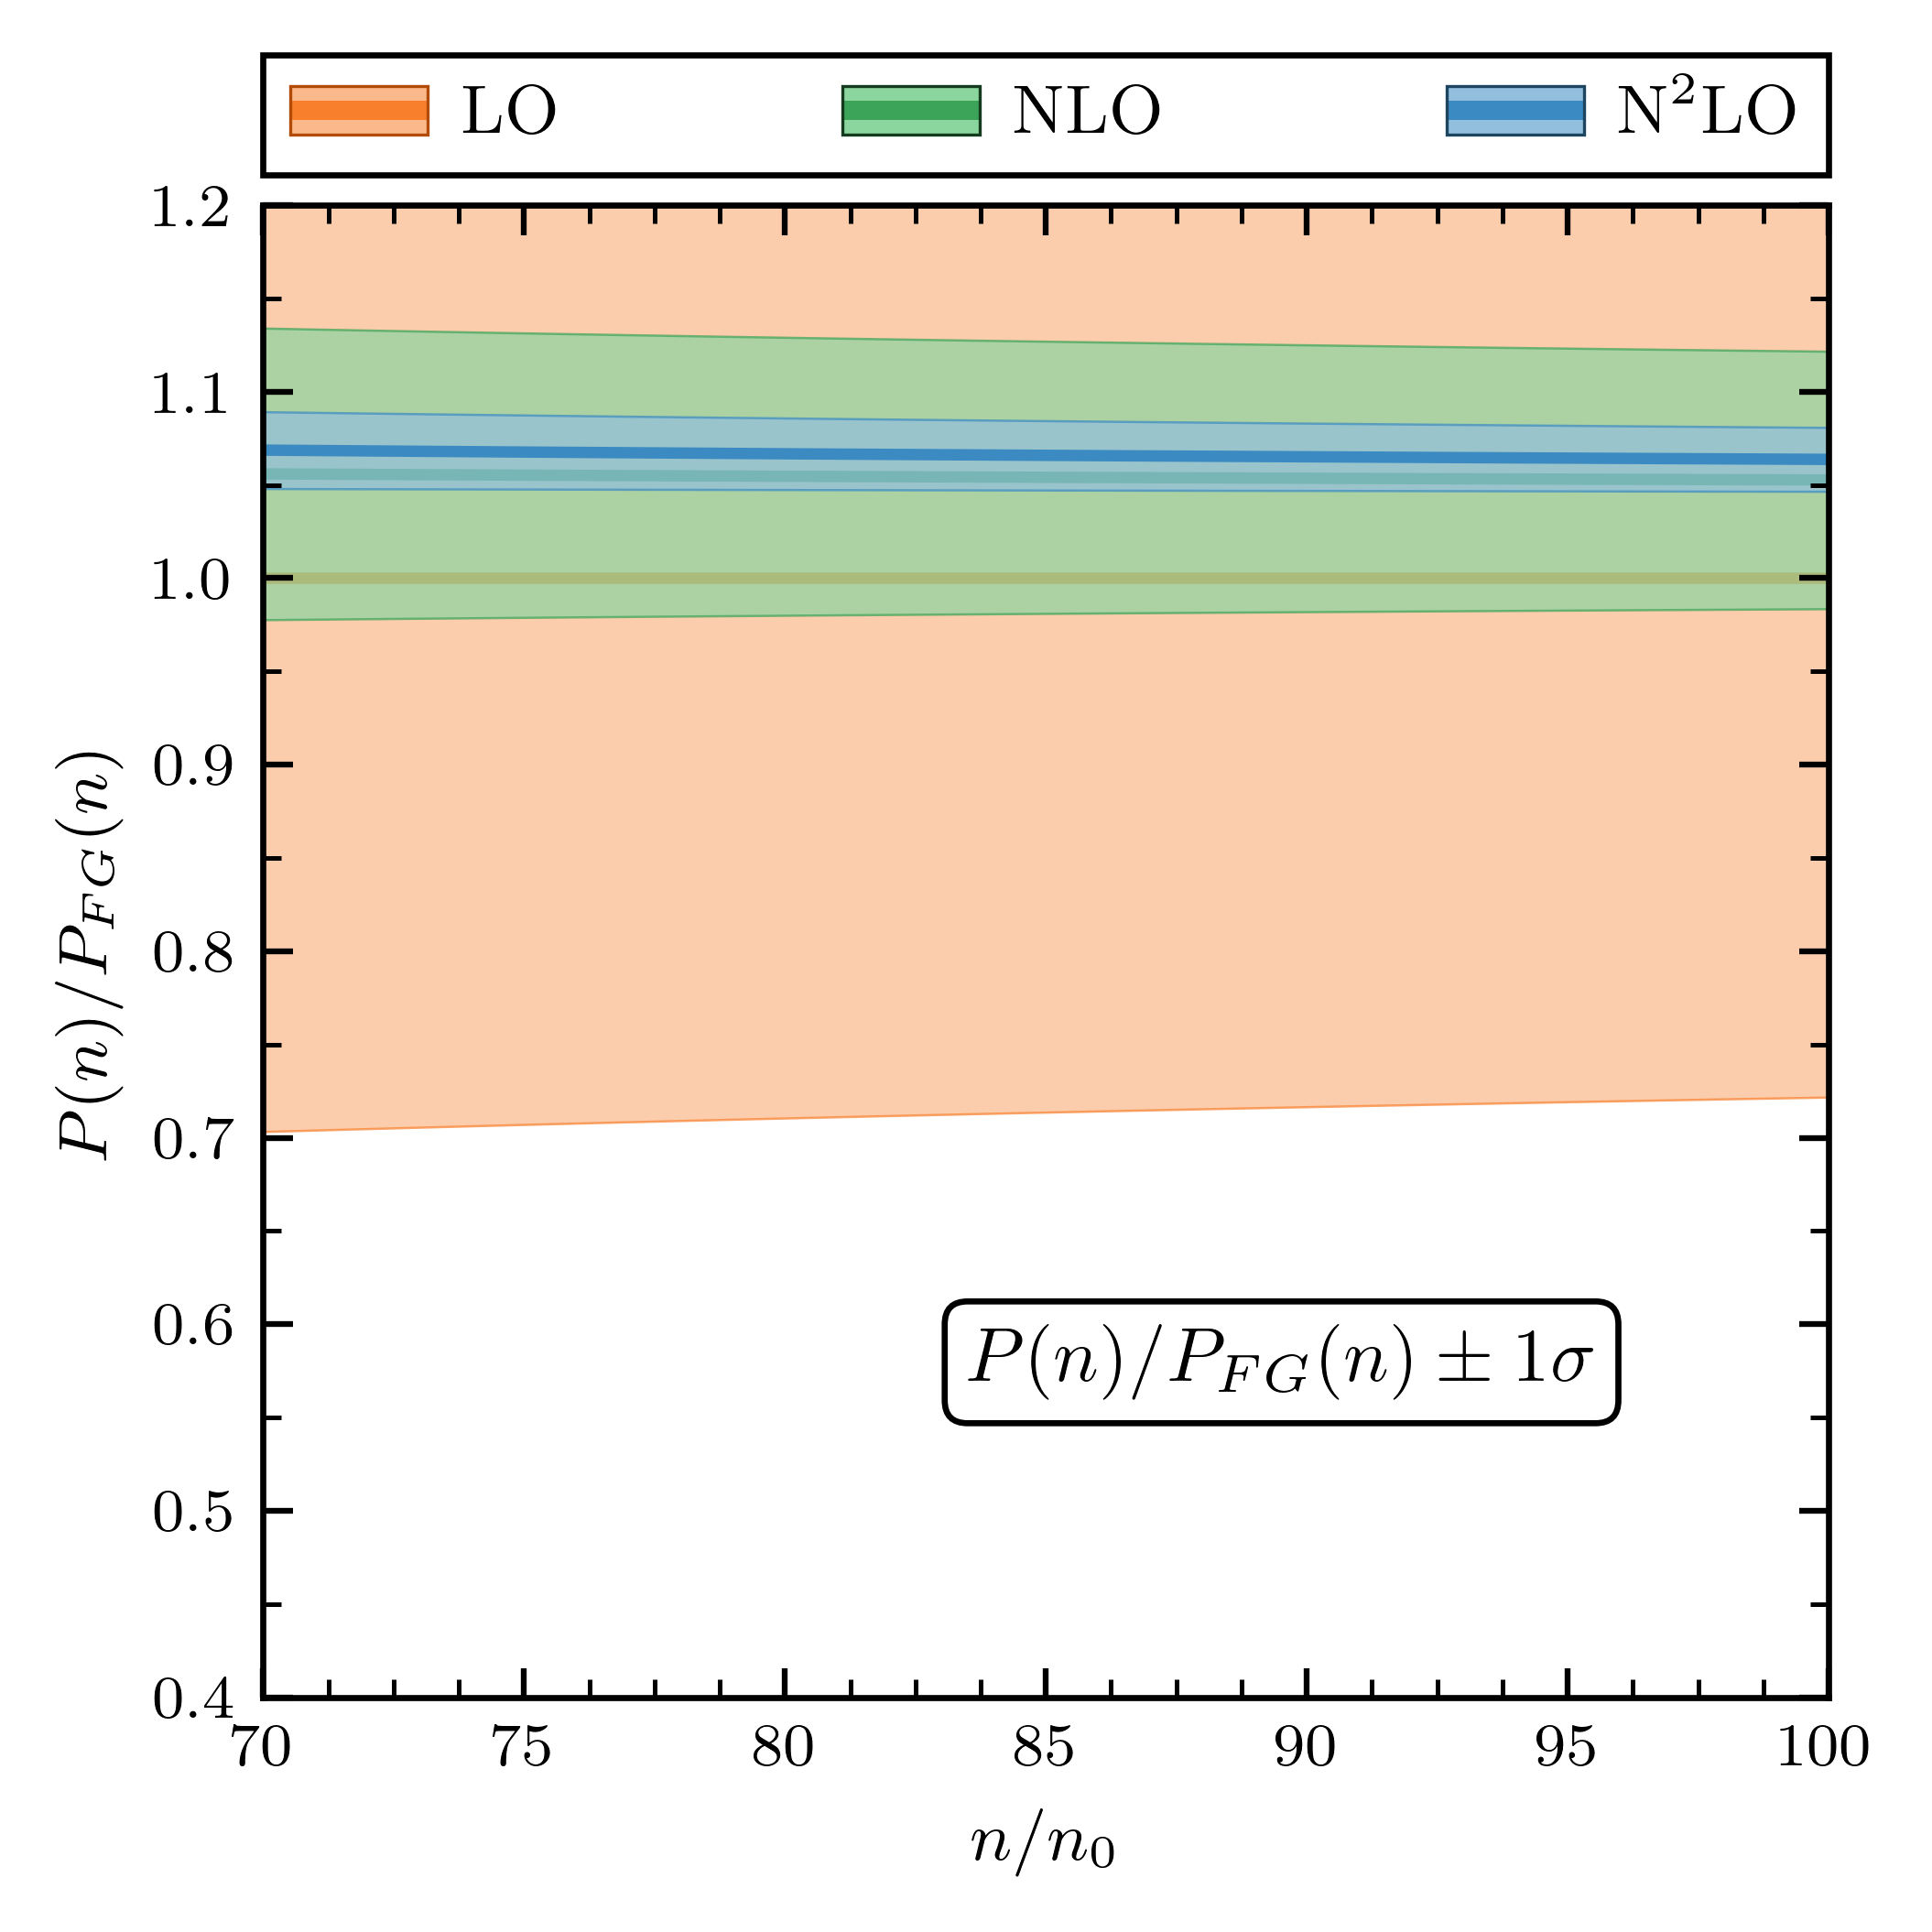

In [98]:
X = mu_n[:,None]
X_FG = mu_FG[:,None]
labels = [r'LO', r'NLO', r'N$^{2}$LO']
labels_original = [r'LO original', r'NLO original', r'N$^{2}$LO original']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
for i in range(3):
    ax.plot(dens/n0, corrected_pressure[:, i]/pqcd.yref(X_FG), zorder=i-1, c=colors[i], label=labels[i])
    ax.fill_between(dens/n0, (corrected_pressure[:, i] + 1.0*std_trunc[:,i])/pqcd.yref(X_FG), (corrected_pressure[:, i] - 1.0*std_trunc[:,i])/pqcd.yref(X_FG),
                    zorder=i-1, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=0.7)
    ax.set_ylim(0.4,1.2)
    ax.set_xlim(min(dens)/n0, max(dens)/n0)
    ax.set_ylabel(r'$P(n)/P_{FG}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$P(n)/P_{FG}(n) \pm 1\sigma$'
ax.text(
    0.45, 0.25, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors, )
#fig.savefig('pqcd_pressure_n.pdf')

In [99]:
# store the P_FG(n) values, unscaled, for plotting against the unscaled result of Chiral EFT
pressure_FG = pqcd.yref(mU_FG)*conversion

# # write this to a file if correct number of points (avoid overwrite)
if dens.size >= 600:
    np.savez('data/eos_data/pqcd_fg_data_alphas_onlyc2', density=dens, dens_scaled=dens/n0, mean=pressure_FG)
else:
    print('Not saved.')

Not saved.


Number of points in training set: 2
Number of points in validation set: 4

Training set: 
 [[1.08541326]
 [1.15792718]]

Validation set: 
 [[1.11848078]
 [1.15088317]
 [1.18155706]
 [1.21071601]]
0.8431076949421239
Std. dev. expected value: 0.8431076949421239
Calculated value : 0.4523467360813045
Trained kernel:  RBF(length_scale=6.89e+03) + WhiteKernel(noise_level=1e-05)
Diagnostic kernel:  RBF(length_scale=6.89e+03) + WhiteKernel(noise_level=1e-05)
[[0.71083769 0.71083059 0.71083059 0.71083059]
 [0.71083059 0.71083769 0.71083059 0.71083059]
 [0.71083059 0.71083059 0.71083769 0.71083059]
 [0.71083059 0.71083059 0.71083059 0.71083769]]
Condition number: 400000.9999925178


/Users/alexandra/Documents/EOSBMM/buqeyenm/src/truncation_error.py:341: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout();


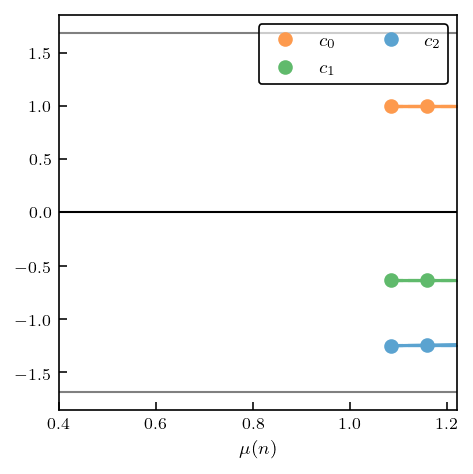

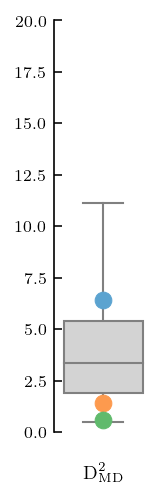

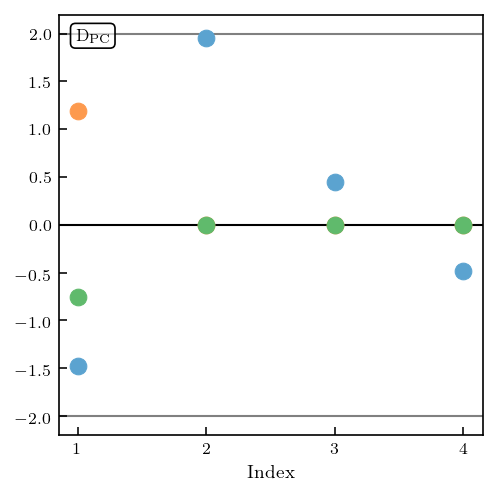

In [100]:
# take a look at the diagnostics
trunc_new.diagnostics(dx_train=50, dx_test=80)

In [101]:
# save scaled results in an npz file
mean_pressure_scaled = np.zeros([len(dens), 3])
std_pressure_scaled = np.zeros([len(dens), 3])
cov_pressure_scaled = np.zeros([len(dens), len(dens), 3])

scale = pqcd.yref(X_FG)

for i in range(3):
    mean_pressure_scaled[:,i] = corrected_pressure[:,i]/pqcd.yref(X_FG)
    std_pressure_scaled[:,i] = std_trunc[:,i]/pqcd.yref(X_FG)

for i in range(3):
    for j in range(len(dens)):
        for k in range(len(dens)):
            cov_pressure_scaled[j,k,i] = cov_trunc[j,k,i]/(scale[j]*scale[k])

# write this to a file if size is correct
if dens.size >= 600:
    np.savez('data/eos_data/pressure_pqcd_data_scaled_expQ_alphas_onlyc2', density=dens, dens_scaled=dens/n0, mean=mean_pressure_scaled, std_dev=std_pressure_scaled, \
             cov=cov_pressure_scaled)
    # open the file here and check it
    npzfile = np.load('pressure_pqcd_data_scaled_expQ.npz')
    npzfile.files

    print(npzfile['density'].shape, npzfile['dens_scaled'].shape, npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

    print(np.sqrt(np.diag(cov_pressure_scaled[:,:,2])) - std_pressure_scaled[:,2])
else:
    print('Not saved.')

Not saved.


In [102]:
# print the whole thing
print('Results at 100*n0:')
print('LO:',(corrected_pressure[:, 0]/pqcd.yref(X_FG))[-1])
print('NLO:',(corrected_pressure[:, 1]/pqcd.yref(X_FG))[-1])
print('N2LO:',(corrected_pressure[:, 2]/pqcd.yref(X_FG))[-1]) 

Results at 100*n0:
LO: 1.0
NLO: 1.0526609453539095
N2LO: 1.0637126151917922


---

## Speed of sound calculation

Analytically, this can be expressed as

$$
c_{s}^{2} = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n}\left[\frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{1}{\mu} \frac{\partial P}{\partial n}
$$

We can obtain both of these quantities quite easily, and we can even, instead of taking the derivative of $P$ with respect to $n$, use the logarithmic derivative form of the above equation, which reads as

$$
c_{s}^{2} = \frac{d\ln{\mu}}{d\ln{n}} = \frac{n}{\mu}\frac{\partial \mu}{\partial n}.
$$

Here, we'll need the values of $n$, $\mu$, and $\frac{\partial \mu}{\partial n}$, so let's check to see how convenient it is to obtain these with our new KLW inversion technique. 

For the speed of sound from the GP, we'll eventually need this expression for the energy density,

$$
\varepsilon(n) = n \left[\frac{\varepsilon(n_{i})}{n_{i}} + \int_{n_{i}}^{n}\frac{P(n')}{n'^{2}} dn' \right]
$$

where we are integrating the results from $P(n)$ KLW calculations, and using an initial density to make sure that we obtain the proper boundary condition for the integral.

__Perhaps we see a discrepancy between the BCs for the integral in pQCD and the results of the integration because we have higher order effects in the integration that would otherwise have been dropped if we'd done this analytically?__

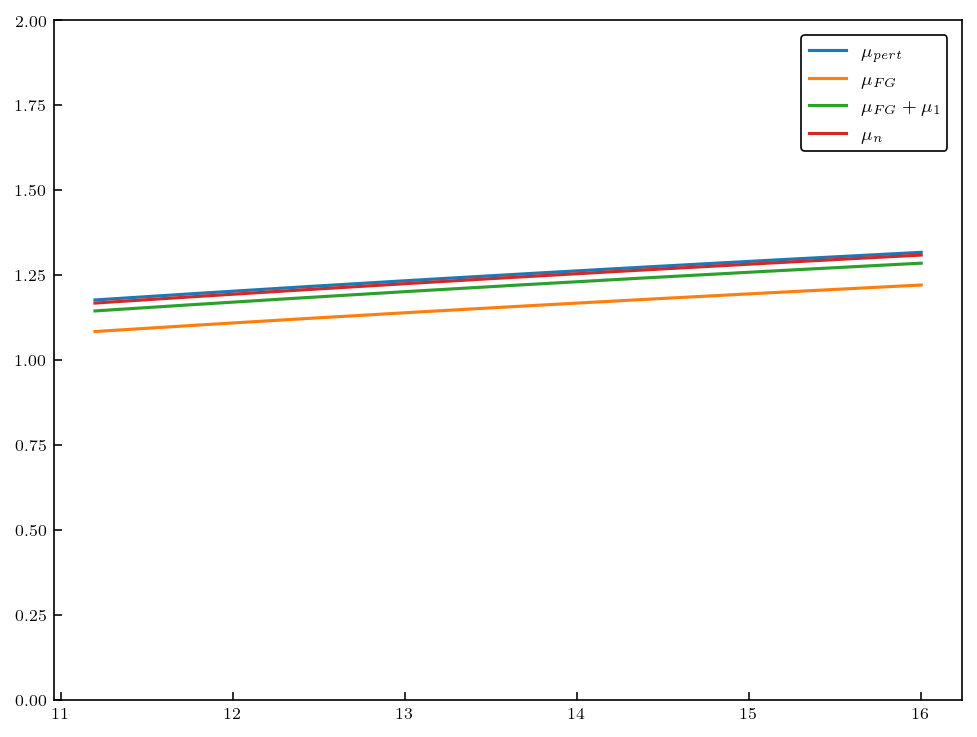

In [103]:
mu_pert = mu_FG + pqcd.mu_1(mu_FG) + pqcd.mu_2(mu_FG)
plt.ylim(0.0, 2.0)
plt.plot(dens, mu_pert, label=r'$\mu_{pert}$')
plt.plot(dens, mu_FG, label=r'$\mu_{FG}$')
plt.plot(dens, (mu_FG + pqcd.mu_1(mu_FG)), label=r'$\mu_{FG} + \mu_{1}$')
plt.plot(dens, mu_n, label=r'$\mu_n$')
plt.legend()

In [104]:
# calculate the speed of sound in the same manner as done for the mixed model to find any inconsistencies
from utils import speed_of_sound
import scipy.integrate as scint
import scipy.interpolate as scinterp

hbarc = 197.327 # MeV fm

# dictionary of dictionary of pressures
pres_dict_FG = {
    'mean': corrected_pressure[:,0]*conversion,
    'std_dev': std_trunc[:,0]*conversion
}
pres_dict_NLO = {
    'mean': corrected_pressure[:,1]*conversion,
    'std_dev': std_trunc[:,1]*conversion
}

pres_dict_N2LO = {
    'mean': corrected_pressure[:,2]*conversion,
    'std_dev': std_trunc[:,2]*conversion
}

# total dictionary of dictionaries
pres_dict = {
    'FG': pres_dict_FG,
    'NLO': pres_dict_NLO,
    'N2LO': pres_dict_N2LO
}

def boundary_conditions(dens, pres_dict, index=0):
    
    # constants
    hbarc = 197.327 # Mev fm
    
    # unpack dictionary
    pres_FG = pres_dict['FG']
    pres_NLO = pres_dict['NLO']
    pres_N2LO = pres_dict['N2LO']
    
    # set up new dictionary for eps(n) BCs
    edens_FG = {}
    edens_NLO = {}
    edens_N2LO = {}
    
    # FG BCs
    edens_FG['mean'] = ((3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * dens/2.0)**(4.0/3.0) * hbarc)[index]
    edens_FG['lower'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']-pres_dict_FG['std_dev']))[index]
    edens_FG['upper'] = (dens*3*1000.*mu_FG - (pres_dict_FG['mean']+pres_dict_FG['std_dev']))[index]
    
    # NLO BCs
    edens_NLO['mean'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                         (pres_dict_NLO['mean'] - pres_dict_FG['mean']))[index]
    edens_NLO['lower'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) - \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    edens_NLO['upper'] = ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens \
    - ((pres_dict_NLO['mean'] - pres_dict_FG['mean']) + \
       (pres_dict_NLO['std_dev']-pres_dict_FG['std_dev'])))[index]
    
    # N2LO BCs
    edens_N2LO['mean'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                          (pres_dict_N2LO['mean'] - pres_dict_NLO['mean']))[index]
    edens_N2LO['lower'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) - \
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
    edens_N2LO['upper'] = ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                           ((pres_dict_N2LO['mean'] - pres_dict_NLO['mean']) +\
                            (pres_dict_N2LO['std_dev']-pres_dict_NLO['std_dev'])))[index]
    
    # add corrections to single out each order
    edens_NLO['mean'] += edens_FG['mean']
    edens_NLO['lower'] += edens_FG['lower']
    edens_NLO['upper'] += edens_FG['upper']
    
    edens_N2LO['mean'] += edens_NLO['mean']
    edens_N2LO['lower'] += edens_NLO['lower']
    edens_N2LO['upper'] += edens_N2LO['upper']

    # combine into dictionary and return
    edens_dict = {
        'FG': edens_FG,
        'NLO': edens_NLO,
        'N2LO': edens_N2LO
    }
    
    return edens_dict

# run the boundary condition function
edens_dict = boundary_conditions(dens, pres_dict, index=-1)

# run speed of sound and plot
dens_cs2, cs2_FG, cs2_mu_FG, cs2_log_FG, edens_FG, mu_dict_FG = \
speed_of_sound(dens, pres_dict_FG, edens_dict['FG'], integrate='backward')
_, cs2_NLO, cs2_mu_NLO, cs2_log_NLO, edens_NLO, mu_dict_NLO = \
speed_of_sound(dens, pres_dict_NLO, edens_dict['NLO'], integrate='backward')
_, cs2_N2LO, cs2_mu_N2LO, cs2_log_N2LO, edens_N2LO, mu_dict_N2LO = \
speed_of_sound(dens, pres_dict_N2LO, edens_dict['N2LO'], integrate='backward')

Boundary point:  11.2
NLO numerical integration:  28751.51071467546
NLO calculation from pQCD:  28846.18802470982
Backward difference:  94.67731003435983


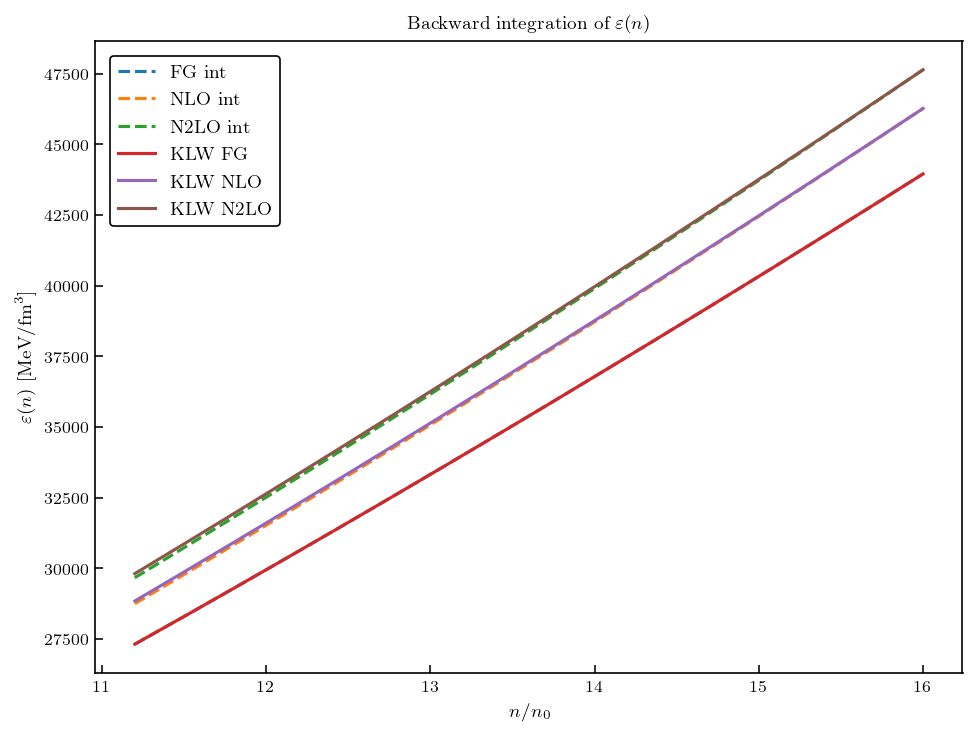

In [105]:
plt.plot(dens_cs2, edens_FG['mean'], linestyle='dashed', label=r'FG int')
plt.plot(dens_cs2, edens_NLO['mean'], linestyle='dashed', label=r'NLO int')
plt.plot(dens_cs2, edens_N2LO['mean'], linestyle='dashed', label=r'N2LO int')
eps_n_FG = ((3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * dens/2.0)**(4.0/3.0) * hbarc)
eps_n_NLO_all = eps_n_FG + ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                         (pres_dict_NLO['mean'] - pres_dict_FG['mean']))
eps_n_N2LO_all = eps_n_NLO_all + ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                          (pres_dict_N2LO['mean'] - pres_dict_NLO['mean']))
plt.plot(dens, eps_n_FG, label=r'KLW FG')
plt.plot(dens, eps_n_NLO_all, label=r'KLW NLO')
plt.plot(dens, eps_n_N2LO_all, label=r'KLW N2LO')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$\varepsilon(n)$ [MeV/fm$^{3}$]')
plt.title(r'Backward integration of $\varepsilon(n)$')
plt.legend()
plt.legend()

print('Boundary point: ', dens_cs2[0])
print('NLO numerical integration: ', edens_NLO['mean'][0])
print('NLO calculation from pQCD: ', eps_n_NLO_all[0])
print('Backward difference: ', eps_n_NLO_all[0] - edens_NLO['mean'][0])

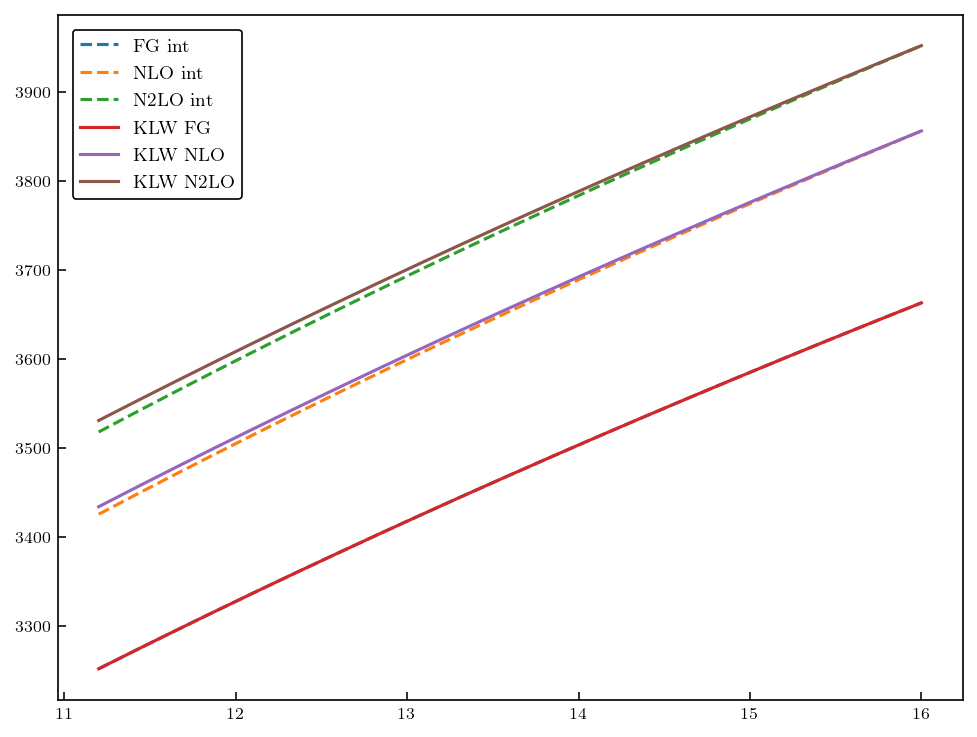

In [106]:
# plot the mu difference between KLW mu and the mu from the integration
plt.plot(dens_cs2, mu_dict_FG['mean'], linestyle='dashed', label=r'FG int')
plt.plot(dens_cs2, mu_dict_NLO['mean'], linestyle='dashed', label=r'NLO int')
plt.plot(dens_cs2, mu_dict_N2LO['mean'], linestyle='dashed', label=r'N2LO int')
plt.plot(dens, 3.*1000.*mu_FG, label=r'KLW FG')
plt.plot(dens, 3.*1000.*(mu_FG + pqcd.mu_1(mu_FG)), label=r'KLW NLO')
plt.plot(dens, 3.*1000.*mu_pert, label=r'KLW N2LO')
plt.legend()

(0.2, 0.4)

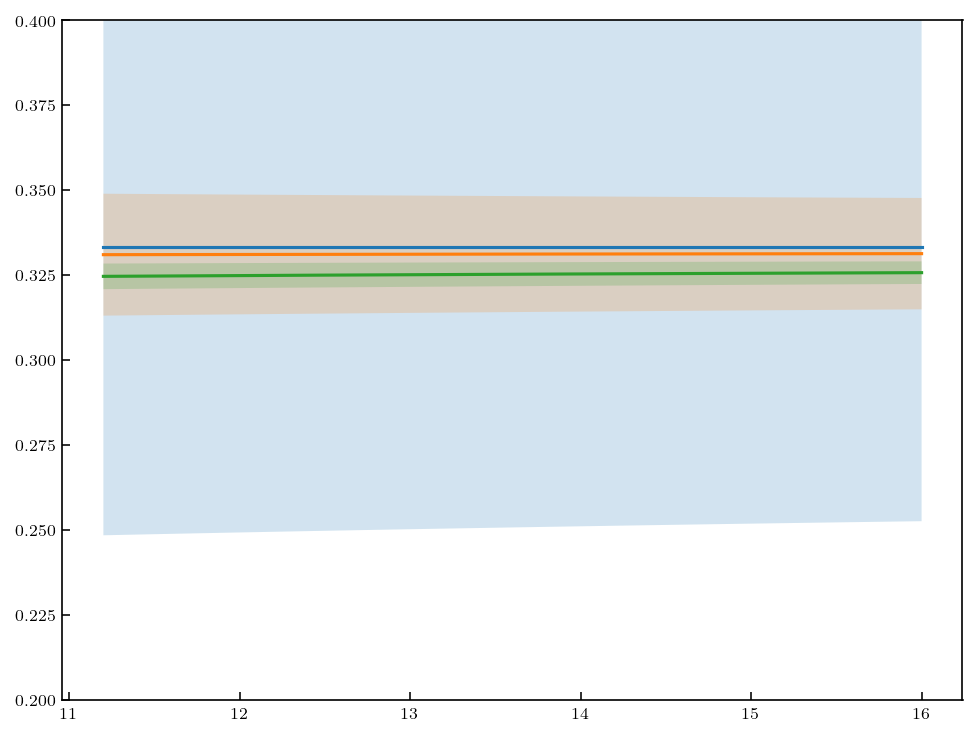

In [107]:
# try an interpolation of dP/dn and then plotting it for cs2
dpdn_FG_interp = scinterp.interp1d(dens, pres_dict_FG['mean'], kind='cubic', fill_value='extrapolate')
dpdn_NLO_interp = scinterp.interp1d(dens, pres_dict_NLO['mean'], kind='cubic', fill_value='extrapolate')
dpdn_NNLO_interp = scinterp.interp1d(dens, pres_dict_N2LO['mean'], kind='cubic', fill_value='extrapolate')

# bands (argh)
dpdn_FG_interp_lower = scinterp.interp1d(dens, pres_dict_FG['mean']-pres_dict_FG['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')
dpdn_FG_interp_upper = scinterp.interp1d(dens, pres_dict_FG['mean']+pres_dict_FG['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')

dpdn_NLO_interp_lower = scinterp.interp1d(dens, pres_dict_NLO['mean']-pres_dict_NLO['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')
dpdn_NLO_interp_upper = scinterp.interp1d(dens, pres_dict_NLO['mean']+pres_dict_NLO['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')

dpdn_NNLO_interp_lower = scinterp.interp1d(dens, pres_dict_N2LO['mean']-pres_dict_N2LO['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')
dpdn_NNLO_interp_upper = scinterp.interp1d(dens, pres_dict_N2LO['mean']+pres_dict_N2LO['std_dev'], \
                                         kind='cubic', fill_value='extrapolate')

# derivative of these values -> higher order effects induced RIGHT HERE
deriv_dpdn_FG = ndt.Derivative(dpdn_FG_interp, step=1e-6, method='central')
deriv_dpdn_FG_lower = ndt.Derivative(dpdn_FG_interp_lower, step=1e-6, method='central')
deriv_dpdn_FG_upper = ndt.Derivative(dpdn_FG_interp_upper, step=1e-6, method='central')

deriv_dpdn_NLO = ndt.Derivative(dpdn_NLO_interp, step=1e-6, method='central')
deriv_dpdn_NLO_lower = ndt.Derivative(dpdn_NLO_interp_lower, step=1e-6, method='central')
deriv_dpdn_NLO_upper = ndt.Derivative(dpdn_NLO_interp_upper, step=1e-6, method='central')

deriv_dpdn_NNLO = ndt.Derivative(dpdn_NNLO_interp, step=1e-6, method='central')
deriv_dpdn_NNLO_lower = ndt.Derivative(dpdn_NNLO_interp_lower, step=1e-6, method='central')
deriv_dpdn_NNLO_upper = ndt.Derivative(dpdn_NNLO_interp_upper, step=1e-6, method='central')

# now check the plot out using the perturbative chemical potential
cs2_interp_FG = deriv_dpdn_FG(dens)/(3.*1000.*mu_FG)
cs2_interp_FG_lower = deriv_dpdn_FG_lower(dens)/(3.*1000.*mu_FG)
cs2_interp_FG_upper = deriv_dpdn_FG_upper(dens)/(3.*1000.*mu_FG)

cs2_interp_NLO = deriv_dpdn_NLO(dens)/(3.*1000.*(mu_FG+pqcd.mu_1(mu_FG)))
cs2_interp_NLO_lower = deriv_dpdn_NLO_lower(dens)/(3.*1000.*(mu_FG+pqcd.mu_1(mu_FG)))
cs2_interp_NLO_upper = deriv_dpdn_NLO_upper(dens)/(3.*1000.*(mu_FG+pqcd.mu_1(mu_FG)))

cs2_interp_NNLO = deriv_dpdn_NNLO(dens)/(3.*1000.*mu_pert)
cs2_interp_NNLO_lower = deriv_dpdn_NNLO_lower(dens)/(3.*1000.*(mu_pert))
cs2_interp_NNLO_upper = deriv_dpdn_NNLO_upper(dens)/(3.*1000.*(mu_pert))

# plot results for numerical derivative (note higher order effects due to the running!)
plt.plot(dens, cs2_interp_FG, label=r'FG')
plt.plot(dens, cs2_interp_NLO, label=r'NLO')
plt.plot(dens, cs2_interp_NNLO, label=r'N2LO')

# try error bands and see how different they are ...
plt.fill_between(dens, cs2_interp_FG_lower, cs2_interp_FG_upper, alpha=0.2)
plt.fill_between(dens, cs2_interp_NLO_lower, cs2_interp_NLO_upper, alpha=0.2)
plt.fill_between(dens, cs2_interp_NNLO_lower, cs2_interp_NNLO_upper, alpha=0.2)

plt.ylim(0.2,0.4)

In [108]:
# calculating the speed of sound wrt dlog(mu)/dlog(n) -> n/mu dmu/dn

# mu_pert definition
mu_pert = mu_FG + pqcd.mu_1(mu_FG) + pqcd.mu_2(mu_FG)
mu_1_total = mu_FG + pqcd.mu_1(mu_FG)
dmu_FGdn = ((3.0*np.pi**2.0/2.0)**(1.0/3.0)*dens**(-2.0/3.0))

# calculate analytical FG result
analytical_FG_log = (dens / (3.0*(3.0*np.pi**2.0*dens/2.0)**(1.0/3.0))) * dmu_FGdn
numerical_FG_log = (dens / (1000.*3.0*mu_FG)) * np.gradient((1000.*3.0*mu_FG), dens)
dens_q = dens*3.0
dmu_FGdnq = (np.pi**2.0/2.0)**(1.0/3.0) * (1.0/3.0) * dens_q**(-2.0/3.0) #dens_q**(-2.0/3.0)

# calculate result for NLO
numerical_NLO_log = ((dens_q / (mu_1_total)) * (dmu_FGdnq * (1.0 + (2.0/(3.0*np.pi))*pqcd.alpha_s(mu_FG, loop=2)))) * hbarc/1000
numerical_N2LO_log = (1.0/3.0) - 5/(108.*np.pi**2.0)*(33 - 2*pqcd.Nf)*pqcd.alpha_s(mu_FG, loop=2)**2.0

FG endpoint: 0.33339631147691956
NLO endpoint: 0.331373135328738
N2LO endpoint 0.32577678791716236
0.3257712390440508


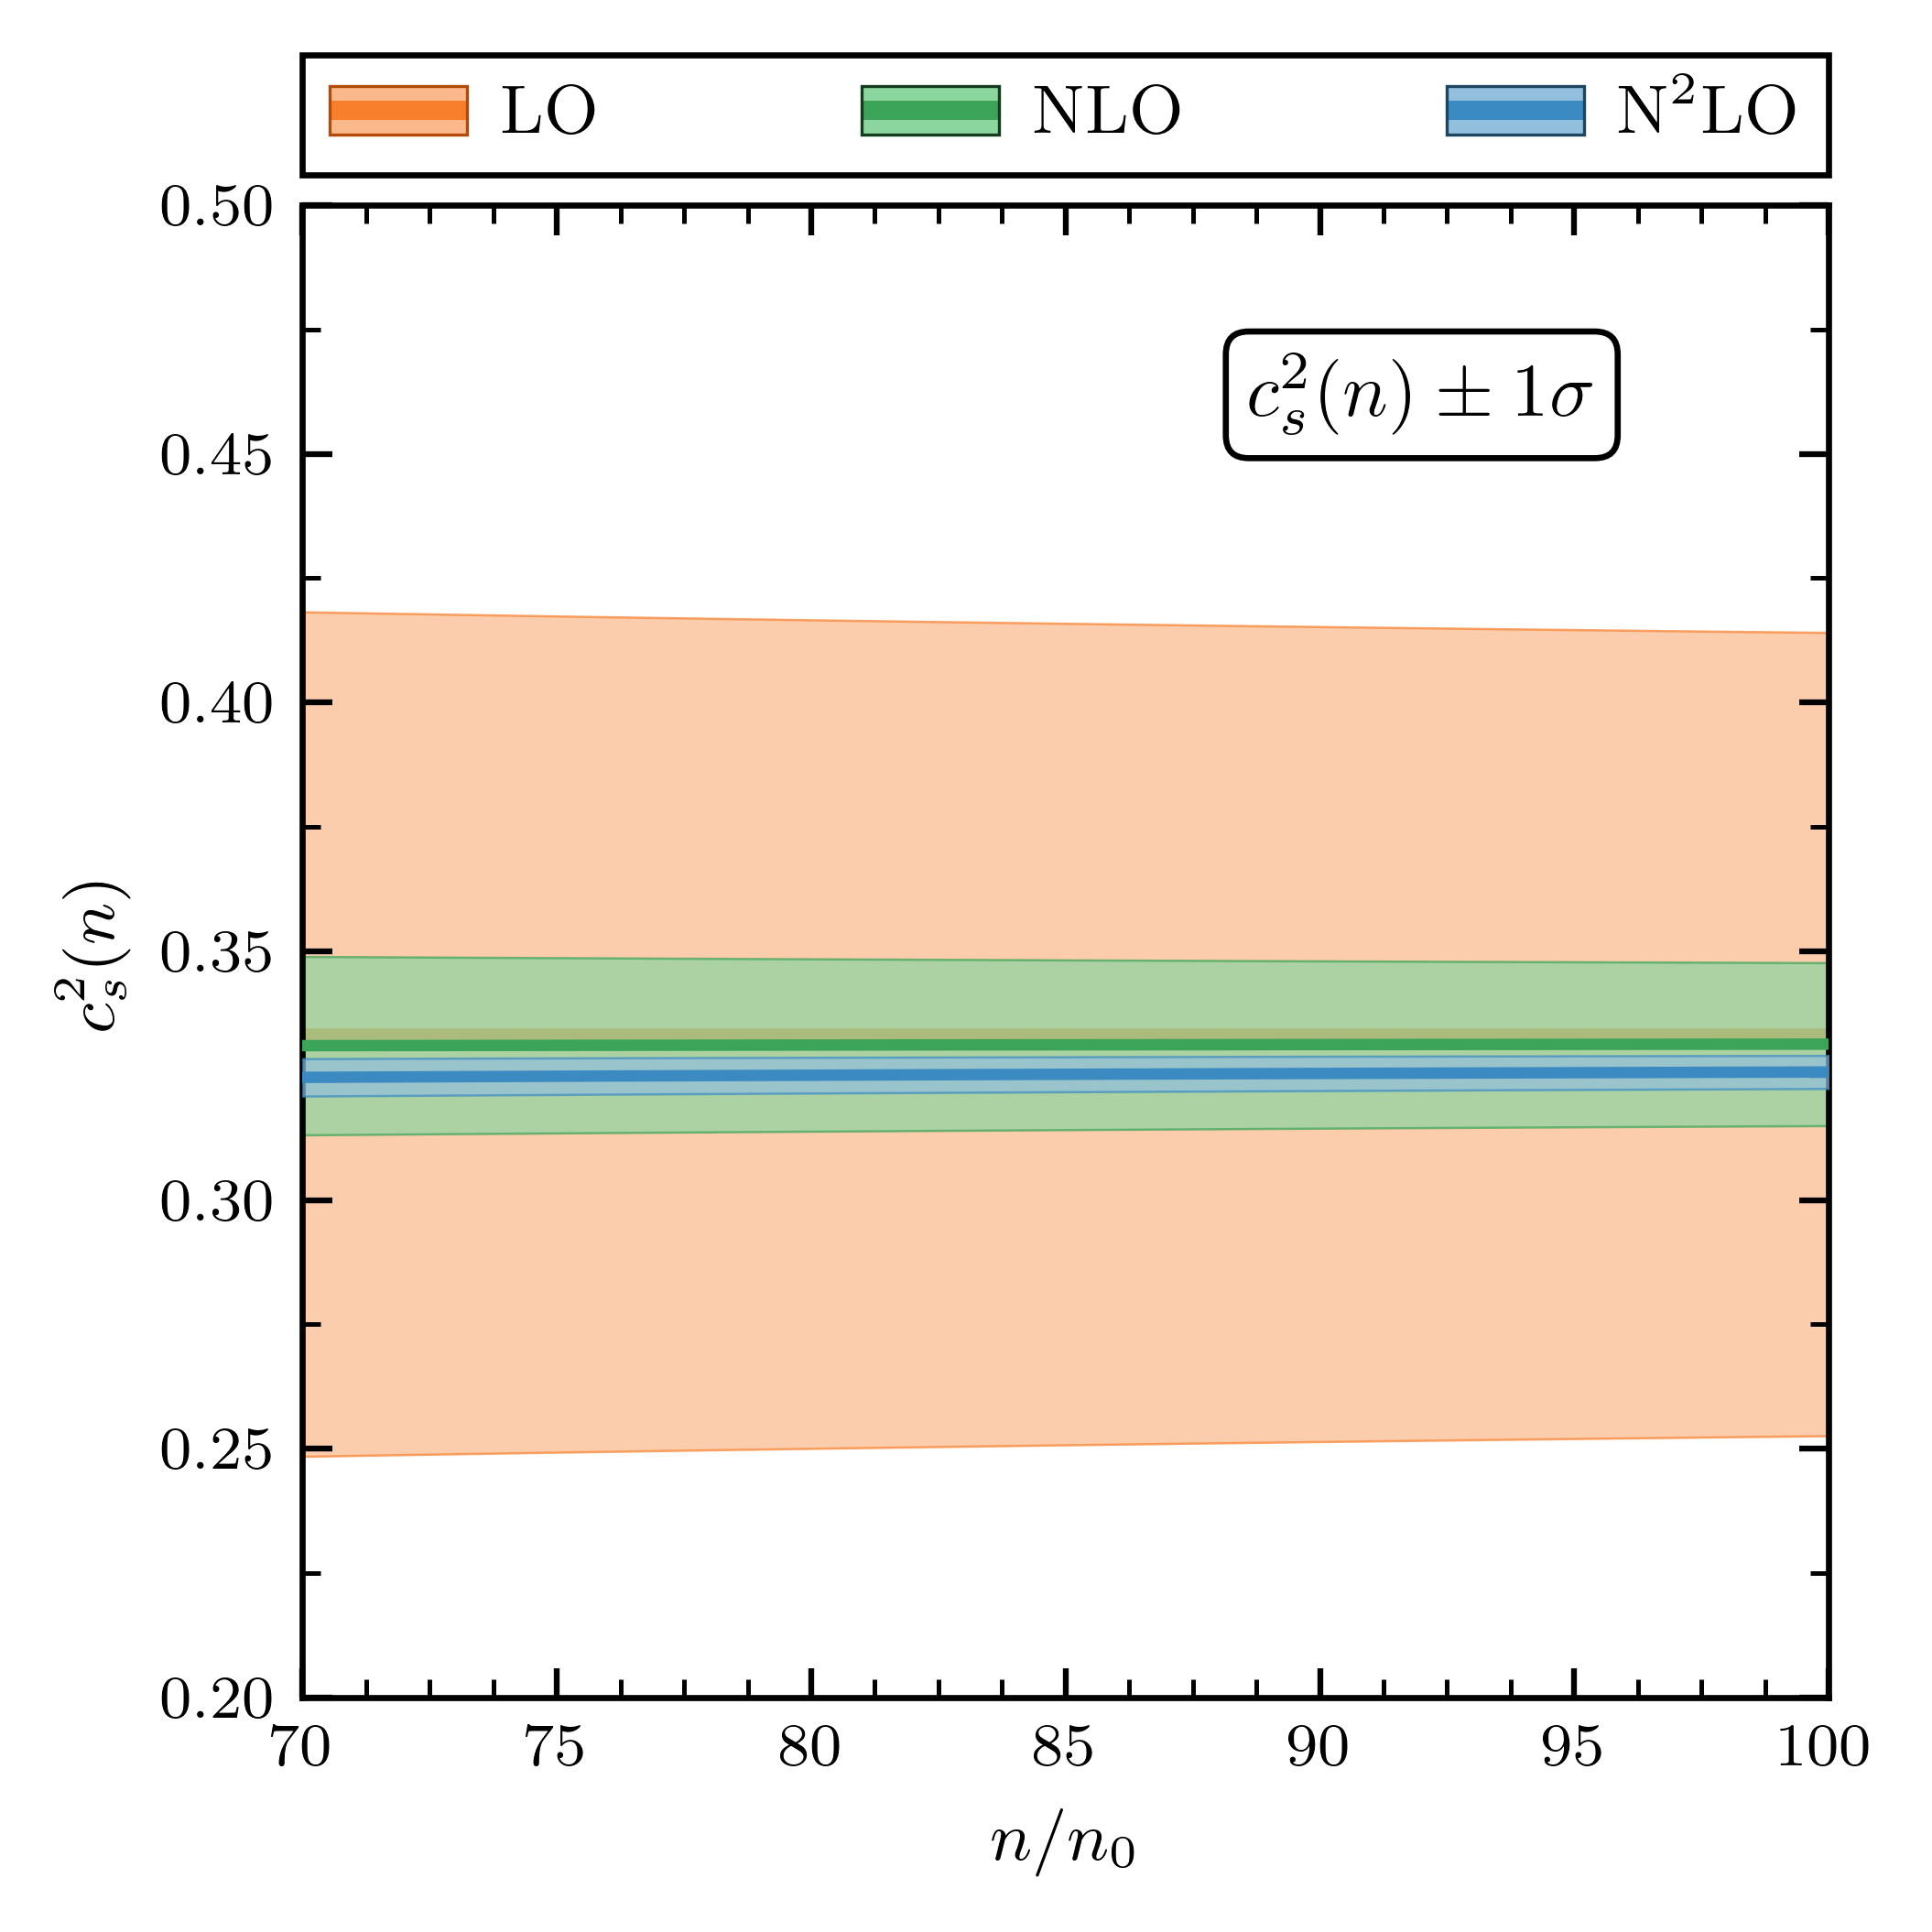

In [109]:
labels = [r'LO', r'NLO', r'N$^{2}$LO']

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
ax.axhline(y=(1.0/3.0), color='grey', linestyle='dotted', zorder=-1, alpha=0.2)
#ax.plot(dens/n0, cs2_FG['mean'], c=colors[0], zorder=1)
ax.plot(dens/n0, cs2_interp_FG, c=colors[0], zorder=1)
# ax.fill_between(dens/n0, cs2_FG['lower'], cs2_FG['upper'],
#                     zorder=0, facecolor=light_colors[0], edgecolor=colors[0], lw=edgewidth, alpha=0.7)
#ax.plot(dens/n0, cs2_NLO['mean'], c=colors[1], zorder=3)
ax.plot(dens/n0, cs2_interp_NLO, c=colors[1], zorder=3)
# ax.fill_between(dens/n0, cs2_NLO['lower'], cs2_NLO['upper'],
#                     zorder=2, facecolor=light_colors[1], edgecolor=colors[1], lw=edgewidth, alpha=0.7)
#ax.plot(dens/n0, cs2_N2LO['mean'], c=colors[2], zorder=5)
ax.plot(dens/n0, cs2_interp_NNLO, c=colors[2], zorder=5)
# ax.fill_between(dens/n0, cs2_N2LO['lower'], cs2_N2LO['upper'],
#                     zorder=4, facecolor=light_colors[2], edgecolor=colors[2], lw=edgewidth, alpha=0.7)

ax.fill_between(dens/n0, cs2_interp_FG_lower, cs2_interp_FG_upper, \
                zorder=0, facecolor=light_colors[0], edgecolor=colors[0], lw=edgewidth, alpha=0.7)
ax.fill_between(dens/n0, cs2_interp_NLO_lower, cs2_interp_NLO_upper, \
                zorder=2, facecolor=light_colors[1], edgecolor=colors[1], lw=edgewidth, alpha=0.7)
ax.fill_between(dens/n0, cs2_interp_NNLO_lower, cs2_interp_NNLO_upper, \
                zorder=4, facecolor=light_colors[2], edgecolor=colors[2], lw=edgewidth, alpha=0.7)

ax.set_ylim(0.2,0.5)
ax.set_xlim(min(dens/n0), max(dens/n0))
#ax.set_xscale('log')
ax.set_ylabel(r'$c_{s}^{2}(n)$')
ax.set_xlabel(r'$n/n_{0}$')
title = r'$c_{s}^{2}(n) \pm 1\sigma$'
ax.text(
    0.62, 0.90, title, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors)
#fig.savefig('pqcd_cs2n.pdf')

# plot the result quickly (noting the issue with scaling back out of P/P_FG)
# FG
# plt.plot(dens/n0, cs2_FG['mean'], label=r'$c_{s, FG}^{2} = \frac{\partial P}{\partial n}\left(\frac{\partial \varepsilon}{\partial n}\right)^{-1}$')
# plt.fill_between(dens/n0, cs2_FG['lower'], cs2_FG['upper'], alpha=0.2)

# # NLO
# plt.plot(dens/n0, cs2_NLO['mean'], linestyle='dashed', label=r'$c_{s, NLO}^{2} = \frac{\partial P}{\partial n}\left(\frac{\partial \varepsilon}{\partial n}\right)^{-1}$')
# plt.fill_between(dens/n0, cs2_NLO['lower'], cs2_NLO['upper'], alpha=0.2)

# N2LO
# plt.plot(dens/n0, cs2_N2LO['mean'], linestyle='dashed', label=r'$c_{s, N2LO}^{2} = \frac{\partial P}{\partial n}\left(\frac{\partial \varepsilon}{\partial n}\right)^{-1}$')
# plt.fill_between(dens/n0, cs2_N2LO['lower'], cs2_N2LO['upper'], alpha=0.2)

print('FG endpoint:', cs2_FG['mean'][-1])
print('NLO endpoint:', cs2_NLO['mean'][-1])
print('N2LO endpoint', cs2_N2LO['mean'][-1])

print(cs2_N2LO['mean'][0])

# try mu_pert for alpha_s just to see
mu_pert = mu_FG + pqcd.mu_1(mu_FG) + pqcd.mu_2(mu_FG)
    
# plot each order from P(mu) result, to check the consistency
# plt.plot(dens/n0, 0.3333*np.ones(len(dens)), label=r'LO cs2(mu)')
# plt.plot(dens/n0, 0.3333*np.ones(len(dens)), linestyle='dotted', label=r'NLO cs2(mu)')
# plt.plot(dens/n0, 0.3333*np.ones(len(dens)) - 0.136033*pqcd.alpha_s(mu_FG, loop=2)**2.0, \
#          label=r'N2LO cs2(mu)') # Nf = 2 currently
plt.show()

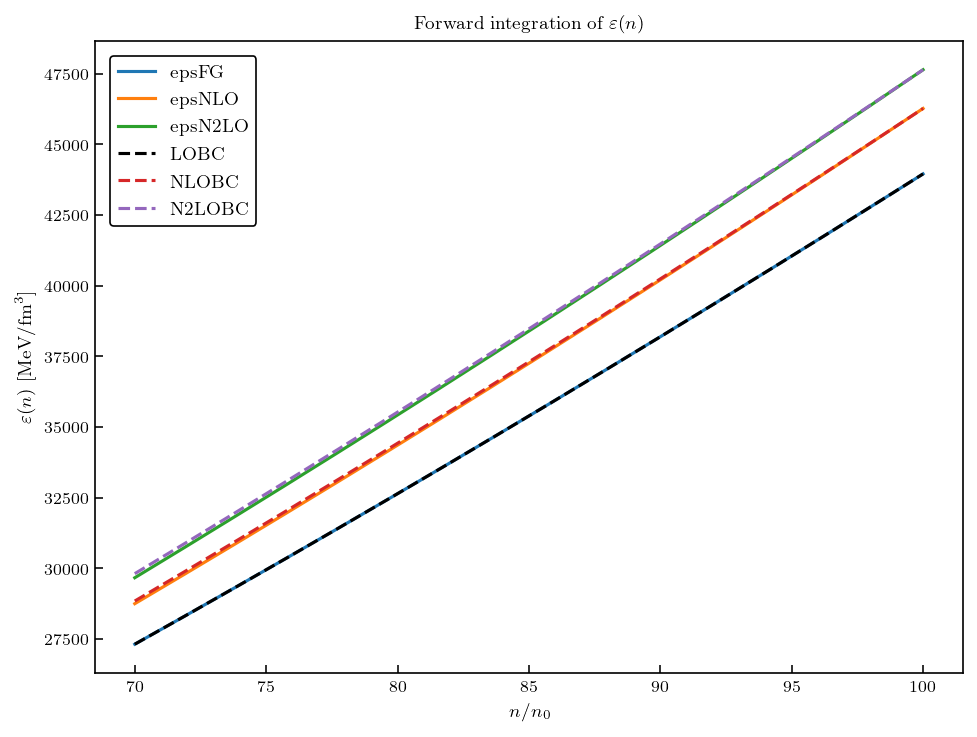

In [110]:
# plot energy density
plt.plot(dens/n0, edens_FG['mean'], label='epsFG')
plt.plot(dens/n0, edens_NLO['mean'], label='epsNLO')
plt.plot(dens/n0, edens_N2LO['mean'], label='epsN2LO')
eps_n_FG = ((3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * dens/2.0)**(4.0/3.0) * hbarc)
eps_n_NLO_all = eps_n_FG + ((pqcd.mu_1(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                         (pres_dict_NLO['mean'] - pres_dict_FG['mean']))
eps_n_N2LO_all = eps_n_NLO_all + ((pqcd.mu_2(mU_FG)[:,0]*1000.) * 3.0 * dens - \
                          (pres_dict_N2LO['mean'] - pres_dict_NLO['mean']))
plt.plot(dens/n0, eps_n_FG, linestyle='dashed', color='black', label='LOBC')
plt.plot(dens/n0, eps_n_NLO_all, linestyle='dashed', label='NLOBC')
plt.plot(dens/n0, eps_n_N2LO_all, linestyle='dashed', label='N2LOBC')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$\varepsilon(n)$ [MeV/fm$^{3}$]')
plt.title(r'Forward integration of $\varepsilon(n)$')
plt.legend()
#plt.savefig('compareedens.pdf')
plt.show()

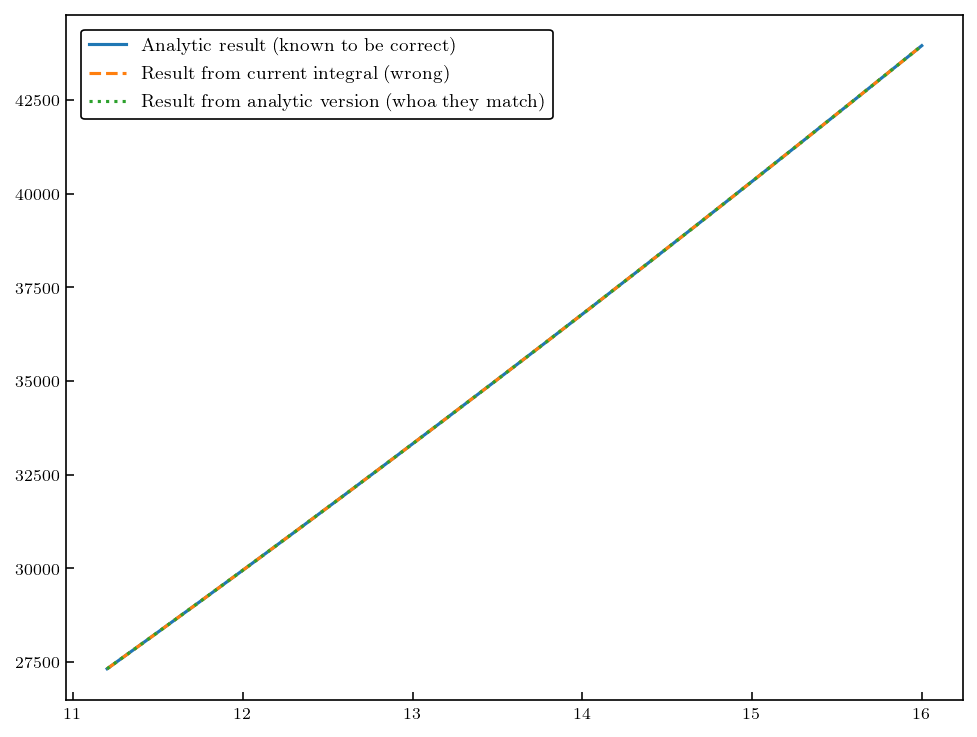

In [111]:
# now let's try a comparison of formulae for energy density
def edens(n): # FG
    
    # quark energy density for Nf=2
    hbarc = 197.327
    return (3.0 / (2 * np.pi**2.0)) * (3.0 * np.pi**2.0 * n/2.0)**(4.0/3.0) * hbarc

def analytic_integration(n, n_i):  # FG
    
    return n * (edens(n_i)/n_i + (3/2)**(7/3) * np.pi**(2/3) * (n**(1/3) - n_i**(1/3)) * hbarc)

# plot stuff from both calculations
plt.plot(dens, edens(dens), label=r'Analytic result (known to be correct)')
plt.plot(dens, edens_FG['mean'], linestyle='dashed', label=r'Result from current integral (wrong)')
plt.plot(dens, analytic_integration(dens, dens[0]), linestyle='dotted', label=r'Result from analytic version (whoa they match)')
plt.legend()

## Save the data for the GP package <a id="gp_data"></a>

In [112]:
if dens[0] == 1.0:
    np.savez('data/eos_data/pqcd_cs2_1.0', density=dens, mean=cs2_N2LO['mean'], \
             lower=cs2_N2LO['lower'], upper=cs2_N2LO['upper'])
    # test viewing
    npzfile = np.load('pqcd_cs2_1.0.npz')
    npzfile.files
elif dens[0] == 11.2:
    np.savez('data/eos_data/pqcd_cs2_11.2_alphas', density=dens, mean=cs2_interp_NNLO, \
             lower=cs2_interp_NNLO_lower, upper=cs2_interp_NNLO_upper) 
else:
    print('Not saved.')

In [113]:
dens_rev = np.linspace(11.2, 16.0, 300)[::-1]